# Procesamiento de los datos
Se realiza el procesamiento de los datos en base a lo obtenido en el notebook de exploración de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import fisher_exact
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.ensemble import ExtraTreesClassifier
import warnings

In [2]:
#Global variables in notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.simplefilter("ignore")
#Global variables in notebook
random_seed = 42
path_data = '../../data/raw/Base.csv'

In [3]:
data = pd.read_csv(path_data)
data.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


## Descripción de los datos

| **Columna**                               | **Tipo de dato**                    | **Descripción**                                                                                                           | **Rangos**               |
|-------------------------------------------|-----------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------|--------------------------|
| income                                    | Numérico                                      | Ingreso anual del solicitante (en forma de decil).                                                                                  | [0.1, 0.9]               |
| name_email_similarity                     | Numérico                                      | Métrica de similitud entre el correo electrónico y el nombre del solicitante. Valores más altos representan mayor similitud.        | [0, 1]                   |
| prev_address_months_count                 | Numérico                                      | Número de meses en la dirección anterior registrada del solicitante, es decir, la residencia anterior del solicitante, si aplica.    | [−1, 380]                |
| current_address_months_count              | Numérico                                      | Meses en la dirección registrada actual del solicitante.                                                                            | [−1, 429]                |
| customer_age                              | Numérico                                      | Edad del solicitante en años, redondeada a la década.                                                                               | [10, 90]                 |
| days_since_request                        | Numérico                                      | Número de días transcurridos desde que se realizó la solicitud.                                                                    | [0, 79]                  |
| intended_balcon_amount                    | Numérico                                      | Monto inicial transferido para la solicitud.                                                                                       | [−16, 114]               |
| payment_type                              | Categórico                                    | Tipo de plan de pago de crédito. 5 valores posibles (anonimizados).                                                                  | -                        |
| zip_count_4w                              | Numérico                                      | Número de solicitudes dentro del mismo código postal en las últimas 4 semanas.                                                     | [1, 6830]                |
| velocity_6h                               | Numérico                                      | Velocidad de las aplicaciones totales realizadas en las últimas 6 horas, es decir, el número promedio de solicitudes por hora.      | [−175, 16818]            |
| velocity_24h                              | Numérico                                      | Velocidad de las aplicaciones totales realizadas en las últimas 24 horas, es decir, el número promedio de solicitudes por hora.     | [1297, 9586]             |
| velocity_4w                               | Numérico                                      | Velocidad de las aplicaciones totales realizadas en las últimas 4 semanas, es decir, el número promedio de solicitudes por hora.    | [2825, 7020]             |
| bank_branch_count_8w                      | Numérico                                      | Número total de solicitudes en la sucursal bancaria seleccionada en las últimas 8 semanas.                                         | [0, 2404]                |
| date_of_birth_distinct_emails_4w          | Numérico                                      | Número de correos electrónicos de solicitantes con la misma fecha de nacimiento en las últimas 4 semanas.                           | [0, 39]                  |
| employment_status                         | Categórico                                    | Estado de empleo del solicitante. 7 valores posibles (anonimizados).                                                                | -                        |
| credit_risk_score                         | Numérico                                      | Puntuación interna de riesgo de la solicitud.                                                                                       | [−191, 389]              |
| email_is_free                             | Binario                                       | Dominio del correo electrónico de la solicitud (ya sea gratuito o de pago).                                                          | -                        |
| housing_status                            | Categórico                                    | Estado residencial actual del solicitante. 7 valores posibles (anonimizados).                                                      | -                        |
| phone_home_valid                          | Binario                                       | Validez del teléfono fijo proporcionado.                                                                                            | -                        |
| phone_mobile_valid                        | Binario                                       | Validez del teléfono móvil proporcionado.                                                                                            | -                        |
| bank_months_count                         | Numérico                                      | Cuántos meses tiene la cuenta anterior (si la tiene).                                                                               | [−1, 32]                 |
| has_other_cards                           | Binario                                       | Si el solicitante tiene otras tarjetas de la misma entidad bancaria.                                                               | -                        |
| proposed_credit_limit                     | Numérico                                      | Límite de crédito propuesto para el solicitante.                                                                                   | [200, 2000]              |
| foreign_request                           | Binario                                       | Si el país de origen de la solicitud es diferente al del banco.                                                                     | -                        |
| source                                    | Categórico                                    | Fuente en línea de la solicitud. Ya sea navegador (INTERNET) o aplicación (TELEAPP).                                                  | -                        |
| session_length_in_minutes                 | Numérico                                      | Duración de la sesión del usuario en el sitio web bancario en minutos.                                                              | [−1, 107]                |
| device_os                                 | Categórico                                    | Sistema operativo del dispositivo que realizó la solicitud. Los valores posibles son: Windows, macOS, Linux, X11, u otro.            | -                        |
| keep_alive_session                        | Binario                                       | Opción del usuario sobre el cierre de sesión.                                                                                       | -                        |
| device_distinct_emails_8w                 | Numérico                                      | Número de correos electrónicos distintos en el sitio web bancario desde el dispositivo utilizado en las últimas 8 semanas.            | [−1, 2]                  |
| device_fraud_count                        | Numérico                                      | Número de solicitudes fraudulentas con el dispositivo utilizado.                                                                    | [0, 1]                   |
| month                                     | Numérico                                      | Mes en el que se realizó la solicitud.                                                                                              | [0, 7]                   |
| fraud_bool                                | Binario                                       | Si la solicitud es fraudulenta o no.                                                                                                | -                        |


In [4]:
numerical_columns = ['income','name_email_similarity','prev_address_months_count','current_address_months_count','customer_age','days_since_request','intended_balcon_amount','zip_count_4w','velocity_6h','velocity_24h','velocity_4w','bank_branch_count_8w','date_of_birth_distinct_emails_4w','credit_risk_score','bank_months_count','proposed_credit_limit','session_length_in_minutes','device_distinct_emails_8w','month']
categorical_columns = ['payment_type','employment_status','email_is_free','housing_status','phone_home_valid','phone_mobile_valid','has_other_cards','foreign_request','source','device_os','keep_alive_session','fraud_bool']
target_var = 'fraud_bool'

## Valores faltantes y duplicados

##### Como se observo en la exploración de los datos se puedo observar que no existen datos duplicados, si existen valores perdidos pero tienen una relación directa con el fraude de una cuenta bancaria, por lo que se toma la decisión de dejar los valores negativos para representar valores faltantes

## Outliers
### Método del Rango Intercuartílico (IQR)

El Método del Rango Intercuartílico (IQR) es una técnica comúnmente utilizada para identificar y manejar los valores atípicos (outliers) en un conjunto de datos. El IQR se basa en el rango entre el primer cuartil (Q1) y el tercer cuartil (Q3), es decir, el 25% y el 75% de los datos, respectivamente. Esto es comun cuando los datos no siguen una distribución normal como se vio en las etapas anteriores

In [5]:
def detectar_outliers_var(df,input_columns,k=1.5):
    outliers = pd.DataFrame(columns=df.columns)
    
    for col in input_columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - k * IQR
            limite_superior = Q3 + k * IQR
            outliers_col = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
            outliers = pd.concat([outliers, outliers_col], axis=0)
    
    return outliers.drop_duplicates()


def eliminar_outliers_iqr_multi(df, columns, k=1.5):
    df_filtrado = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        
        # Filtrar filas que no son outliers en la columna actual
        df_filtrado = df_filtrado[(df_filtrado[column] >= lower_bound) & (df_filtrado[column] <= upper_bound)]
    
    return df_filtrado

def plot_outliers(df,columns):
    plt.figure(figsize=(20, 16))

    # Crear un boxplot para cada columna numérica
    for i, col in enumerate(columns):
        plt.subplot(5, 4, i + 1)  # Organizar en 5 filas y 4 columnas
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
        plt.tight_layout()

    plt.show()

def bivariante_boxplot_numerical(df,target_var):
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(22, 20))
    columns = df.columns.to_list()
    columns.remove(target_var)

    for i, feature in  enumerate(columns):
        ax = axes[i // 4][i % 4]
        sns.boxplot(data=df, x=target_var, y=feature, ax=ax, boxprops=dict(alpha=.6))
        ax.set_xlabel('')
        ax.set_ylabel(feature)
        ax.set_xticklabels(['Not Fraud', 'Fraud'])

    plt.tight_layout()
    plt.show()

def bivariante_graphs_numerical(df, target_var):
    columns = df.columns.to_list()
    columns.remove(target_var)
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))

    fig.suptitle('Distribución de características numéricas según el estado de fraude')

    for i, feature in enumerate(columns):
        ax = axes[i // 4][i % 4]
        sns.kdeplot(data=df[df[target_var] == 0][feature], fill=True, ax=ax, label='Not Fraud')
        sns.kdeplot(data=df[df[target_var] == 1][feature], fill=True, ax=ax, label='Fraud')
        ax.set_xlabel(feature)
        ax.legend()

    plt.tight_layout()
    plt.show()

def bivariante_graphs_categorial(df, target):
    sns.set(font_scale=1)
    col_analysis = df.columns.to_list()
    col_analysis.remove(target)
    num_subplots = len(col_analysis)
    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6 * num_subplots))
    for i, col in enumerate(col_analysis):
        sns.countplot(data=df, x=col, ax=axes[i], hue=target, order=df[col].value_counts().index)
        ax = axes[i]
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

        ax.set_title(f'Gráfico de Barras Apiladas para {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Conteo')
    plt.tight_layout()
    plt.show()

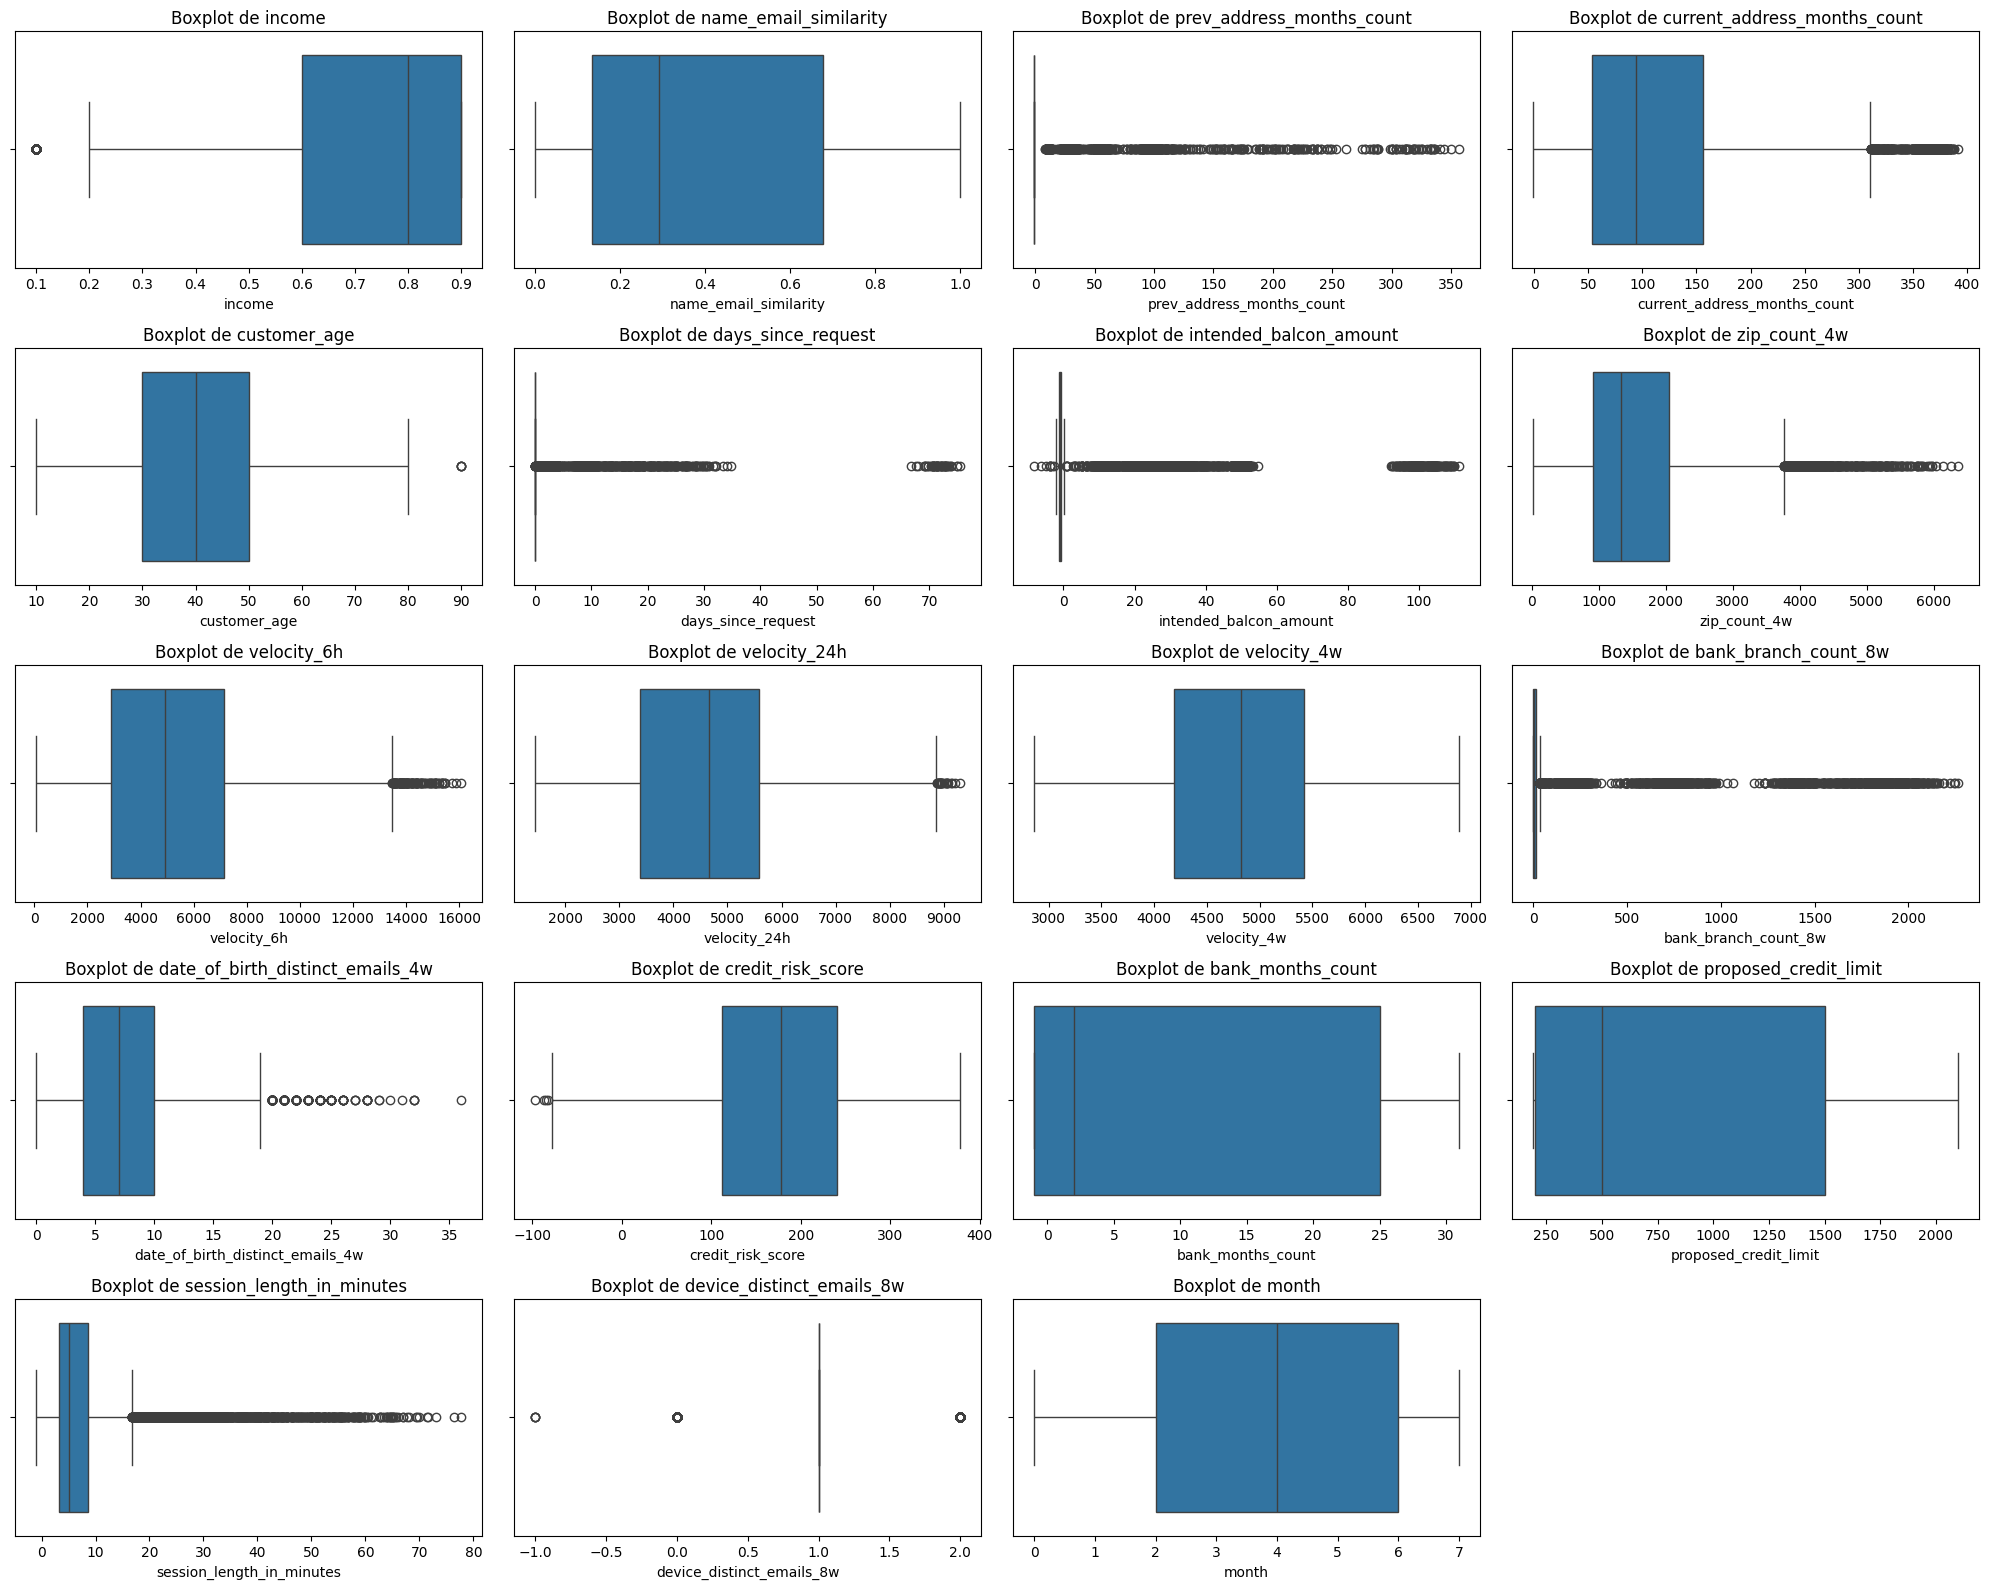

In [6]:
# Definir el tamaño de la figura para ajustarse a todos los boxplots
data_is_fraud = data[data[target_var]==1]
plot_outliers(data_is_fraud,numerical_columns)

In [7]:
##Detectar outliers por la clasificación fraude
outliers_fraud = detectar_outliers_var(df=data_is_fraud, input_columns=numerical_columns,k=2)
outliers_fraud.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
561,1,0.9,0.998248,31,45,30,0.010165,33.067538,AA,525,6883.814598,3655.042385,4327.215795,16,12,CA,273,1,BA,0,1,1,1,2000.0,0,INTERNET,44.536211,windows,0,1,0,0
3275,1,0.9,0.888855,253,3,40,0.003099,-1.061991,AC,1391,3115.724046,5186.475902,6433.414779,0,10,CD,123,1,BB,0,0,-1,0,200.0,0,INTERNET,11.726755,windows,0,1,0,0
5499,1,0.9,0.057550,90,147,30,3.109056,-1.550719,AC,4220,6495.694547,3986.383676,5859.181721,0,18,CA,10,1,BA,0,1,-1,0,200.0,0,INTERNET,1.650819,windows,0,1,0,0
5865,1,0.6,0.739517,189,61,50,0.013636,-1.133785,AC,2687,7126.746914,4677.302988,5948.206800,1,5,CA,93,1,BC,0,1,-1,0,200.0,0,INTERNET,11.280720,linux,0,1,0,0
6591,1,0.9,0.507907,56,5,20,0.017471,-1.937428,AC,1092,8860.578438,7095.300819,6734.156642,0,13,CA,61,1,BC,0,1,-1,0,200.0,0,INTERNET,9.750289,linux,1,1,0,0


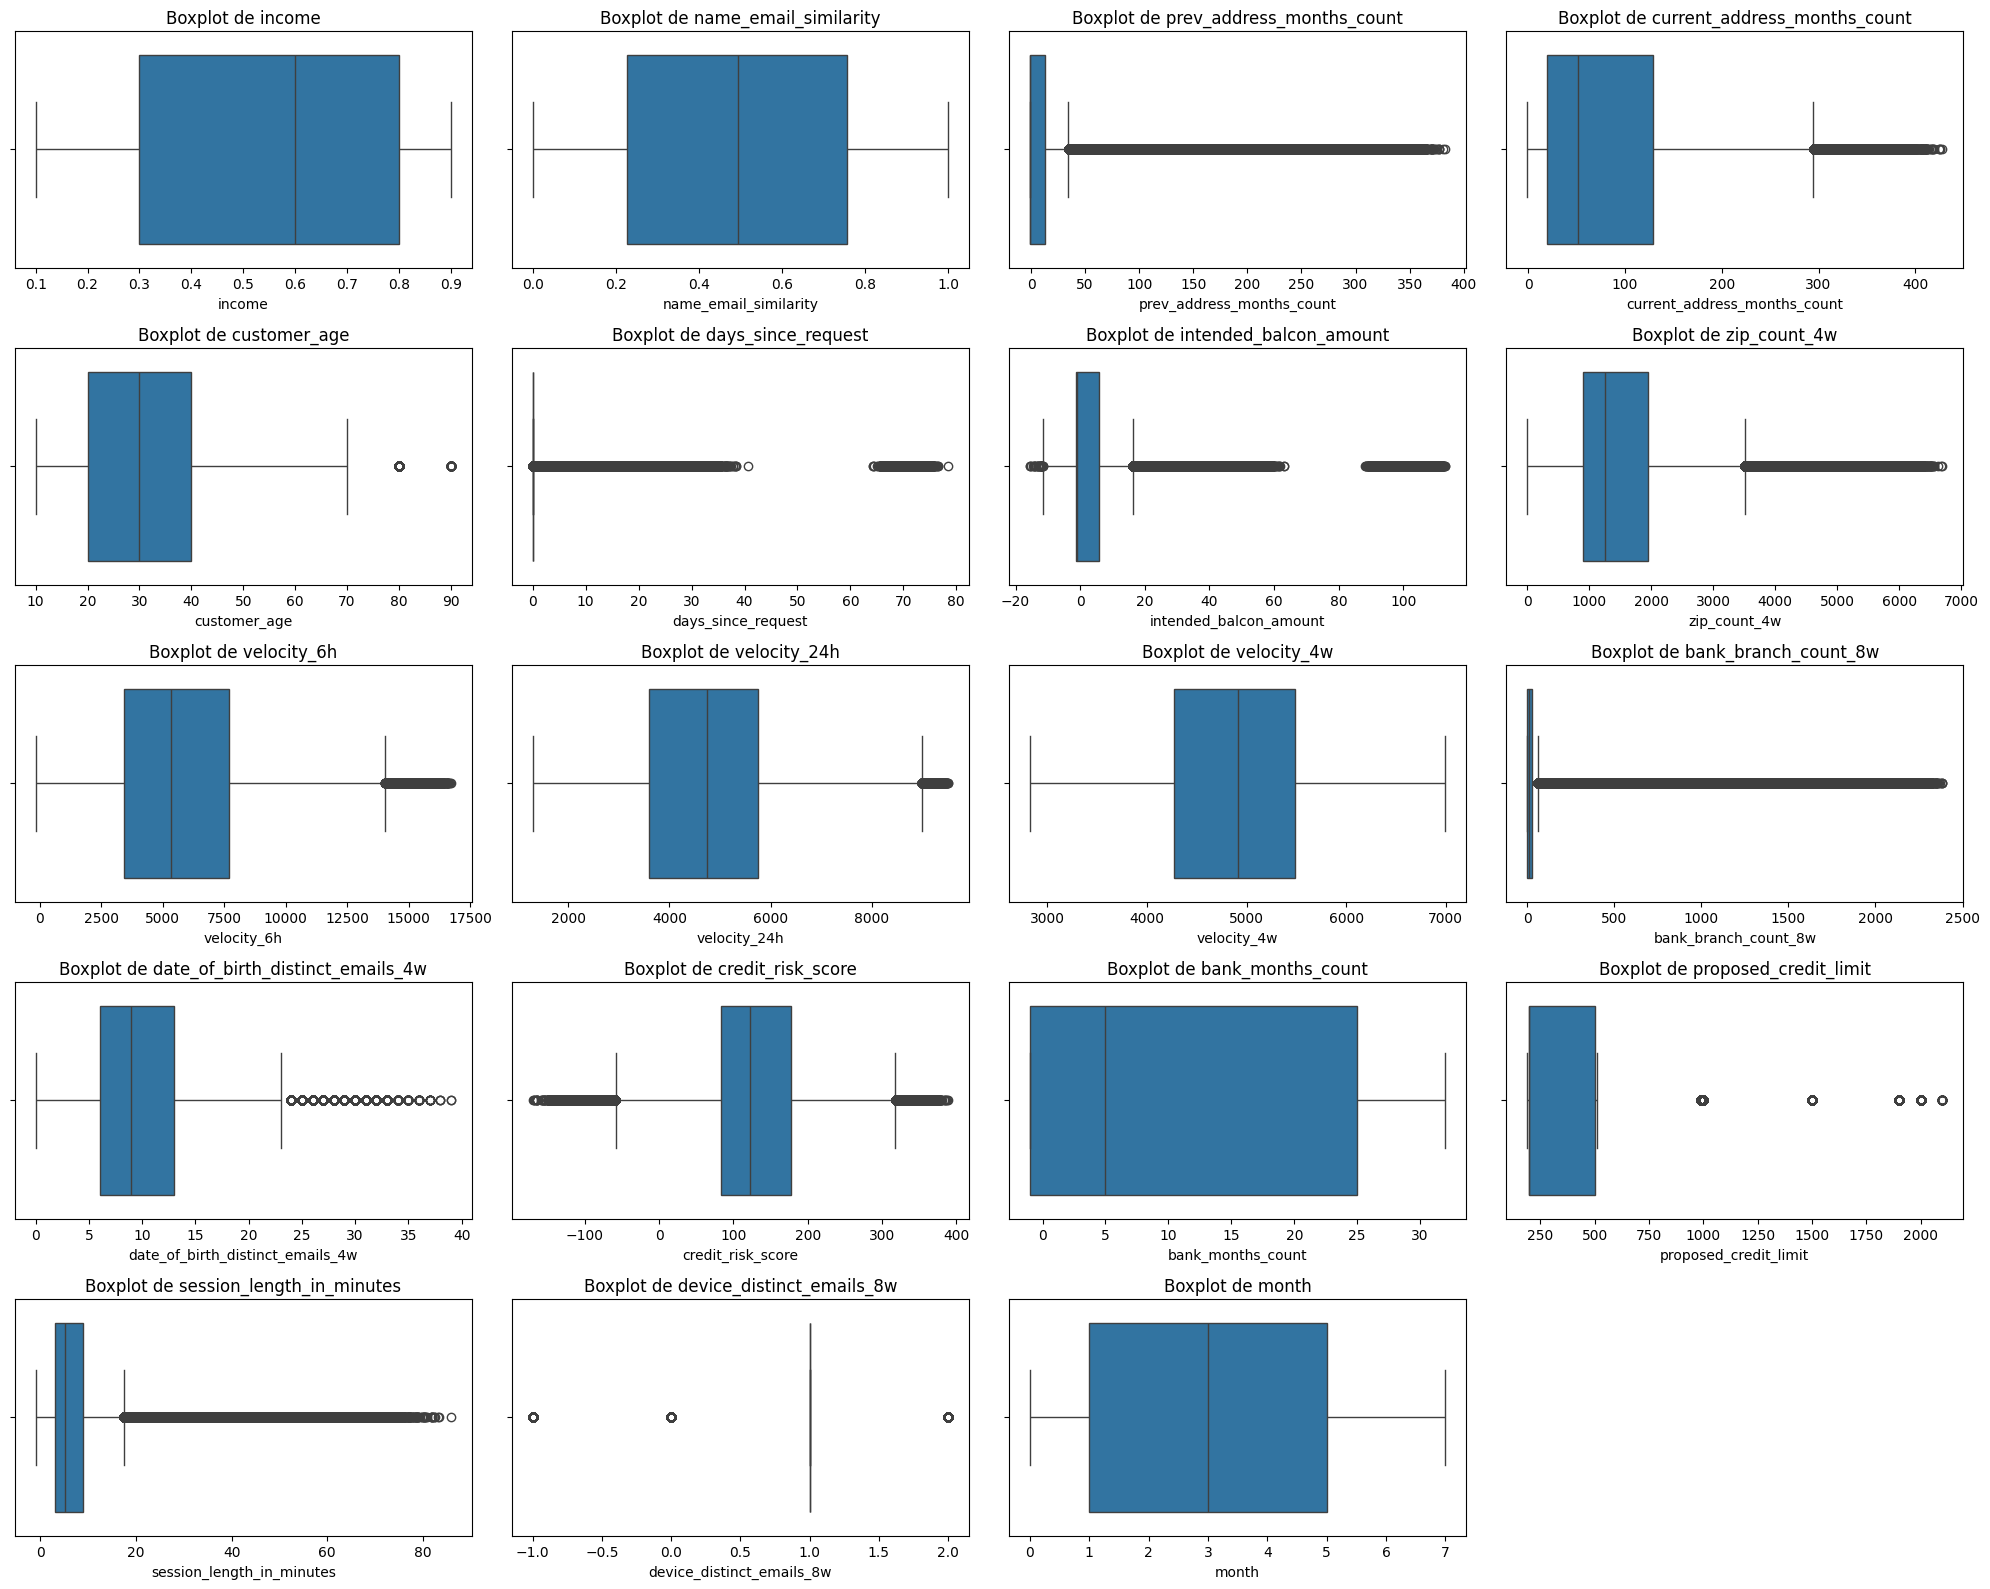

In [8]:
##Detectar outliers por la clasificación no es fraude
data_is_not_fraud = data[data[target_var]==0]
plot_outliers(data_is_not_fraud,numerical_columns)

In [9]:
outliers_not_fraud = detectar_outliers_var(df=data_is_not_fraud, input_columns=numerical_columns,k=2)
outliers_not_fraud.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
37,0,0.6,0.772867,96,124,40,0.015487,-0.959755,AB,4033,7412.064391,5990.690677,6373.249653,0,3,CB,245,0,BA,0,1,28,0,1500.0,0,INTERNET,4.607511,other,1,1,0,0
39,0,0.6,0.030694,48,5,20,0.008314,-0.793166,AB,3601,9482.529231,5369.544378,6373.368036,5,16,CA,142,1,BE,1,1,20,0,500.0,0,INTERNET,3.101606,linux,1,1,0,0
40,0,0.9,0.160079,49,8,20,0.032588,100.669891,AD,587,7942.408980,6873.953008,6830.890289,25,11,CA,114,1,BC,0,1,1,0,500.0,0,INTERNET,14.026596,windows,1,1,0,0
41,0,0.4,0.523423,51,19,20,0.011945,-1.036585,AD,1290,7222.840840,5844.032110,6749.432652,9,22,CA,39,1,BC,1,1,1,0,200.0,0,INTERNET,4.987669,linux,1,1,0,0
51,0,0.7,0.851319,235,29,30,6.909344,13.017865,AA,3659,8023.618319,6968.212492,4990.838362,236,23,CA,18,1,BC,0,1,11,0,1000.0,0,INTERNET,3.885405,linux,1,1,0,0


In [10]:
all_outliers =  pd.concat([outliers_fraud, outliers_not_fraud], ignore_index=True)
all_outliers

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.998248,31,45,30,0.010165,33.067538,AA,525,6883.814598,3655.042385,4327.215795,16,12,CA,273,1,BA,0,1,1,1,2000.0,0,INTERNET,44.536211,windows,0,1,0,0
1,1,0.9,0.888855,253,3,40,0.003099,-1.061991,AC,1391,3115.724046,5186.475902,6433.414779,0,10,CD,123,1,BB,0,0,-1,0,200.0,0,INTERNET,11.726755,windows,0,1,0,0
2,1,0.9,0.057550,90,147,30,3.109056,-1.550719,AC,4220,6495.694547,3986.383676,5859.181721,0,18,CA,10,1,BA,0,1,-1,0,200.0,0,INTERNET,1.650819,windows,0,1,0,0
3,1,0.6,0.739517,189,61,50,0.013636,-1.133785,AC,2687,7126.746914,4677.302988,5948.206800,1,5,CA,93,1,BC,0,1,-1,0,200.0,0,INTERNET,11.280720,linux,0,1,0,0
4,1,0.9,0.507907,56,5,20,0.017471,-1.937428,AC,1092,8860.578438,7095.300819,6734.156642,0,13,CA,61,1,BC,0,1,-1,0,200.0,0,INTERNET,9.750289,linux,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601192,0,0.7,0.533574,30,0,30,0.030628,-1.439334,AD,1414,8060.858277,7642.798539,3093.820558,9,5,CD,22,0,BC,0,1,20,0,200.0,0,INTERNET,7.693720,linux,0,2,0,7
601193,0,0.8,0.530861,-1,211,60,0.028570,-1.587900,AC,1229,1989.004455,2862.092067,3117.978126,0,5,CA,116,0,BA,1,1,-1,1,500.0,0,INTERNET,3.818632,other,0,0,0,7
601194,0,0.9,0.372724,-1,154,50,0.017658,-1.035556,AB,1096,3742.068578,3040.316943,3127.945268,12,6,CA,127,0,BB,0,1,1,0,200.0,0,INTERNET,16.714086,linux,1,2,0,7
601195,0,0.9,0.921701,-1,106,40,0.024914,-1.332939,AB,865,3779.176090,3166.022103,3065.041263,1,6,CA,218,1,BC,0,1,31,0,200.0,0,TELEAPP,-1.000000,other,0,0,0,7


#### Analisis general de los datos outliers

In [11]:
all_outliers.describe(percentiles=[.25, .50, .75, 1]).T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,100%,max
income,601197.000000,0.571664,0.288344,0.100000,0.300000,0.600000,0.800000,0.900000,0.900000
name_email_similarity,601197.000000,0.496175,0.290104,0.000010,0.224435,0.498122,0.757327,0.999999,0.999999
days_since_request,601197.000000,1.695689,6.859435,0.000000,0.007615,0.016306,0.029990,78.456904,78.456904
intended_balcon_amount,601197.000000,14.529774,24.217622,-15.530555,-1.087755,-0.637741,28.189375,112.956928,112.956928
velocity_6h,601197.000000,5856.120905,3076.116942,-155.430730,3539.642515,5567.436026,7951.872924,16715.565404,16715.565404
velocity_24h,601197.000000,4916.819719,1483.046683,1326.966135,3763.593641,4891.408547,5908.929117,9506.896596,9506.896596
velocity_4w,601197.000000,4964.715757,917.960158,2825.748405,4310.792946,5029.465208,5544.083690,6994.764201,6994.764201
proposed_credit_limit,601197.000000,624.660702,559.530570,190.000000,200.000000,200.000000,1000.000000,2100.000000,2100.000000
session_length_in_minutes,601197.000000,8.756129,9.635524,-1.000000,3.337560,5.462466,10.078800,85.899143,85.899143


In [12]:
data_without_outliers = eliminar_outliers_iqr_multi(data,numerical_columns,k=2)
data_without_outliers.reset_index(drop=True,inplace=True)
data_without_outliers

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
1,0,0.8,0.153880,-1,103,40,0.045122,-1.101184,AB,1548,4999.555801,4526.861667,6426.790817,6,7,CA,163,0,BE,1,1,25,1,200.0,0,INTERNET,11.234264,other,1,1,0,0
2,0,0.3,0.523655,21,2,30,0.035206,-0.955737,AB,1781,6979.994002,4335.685346,6624.957942,2,10,CA,35,0,BC,1,0,2,0,200.0,0,INTERNET,5.329387,other,1,1,0,0
3,0,0.9,0.052615,-1,156,30,0.025660,-1.570164,AD,1685,10282.430085,7499.069981,6785.368857,28,16,CB,88,1,BA,0,1,1,0,200.0,0,INTERNET,6.324050,linux,1,1,0,0
4,0,0.9,0.520718,-1,31,50,0.005729,-1.008223,AC,597,2778.119599,6002.721890,6303.077748,12,26,CA,80,1,BC,0,1,10,0,200.0,0,INTERNET,3.731970,linux,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390927,0,0.1,0.951756,-1,111,20,0.026208,-1.054070,AB,430,7560.828680,3333.572279,3064.473608,8,6,CE,105,0,BE,1,1,11,0,200.0,0,INTERNET,2.205068,windows,1,1,0,7
390928,0,0.1,0.736109,-1,59,40,0.003862,17.282748,AA,816,4892.745269,3004.578021,3184.307293,6,3,CB,97,1,BC,1,1,20,0,200.0,0,INTERNET,1.643165,linux,1,1,0,7
390929,0,0.9,0.375426,-1,287,30,0.008465,-0.840388,AB,970,910.586499,3156.493443,3146.595806,14,4,CE,181,1,BB,1,1,15,1,200.0,0,INTERNET,0.959442,other,1,1,0,7
390930,0,0.9,0.824544,-1,193,30,0.009591,0.008307,AC,408,1574.293294,2716.495767,4286.089050,0,5,CA,235,0,BA,1,1,-1,1,1000.0,0,INTERNET,1.504109,macintosh,0,1,0,7


#### Analisis de los datos después de eliminar los outliers
##### Analisis de varaibles numericas

In [13]:
data_without_outliers.describe(percentiles=[.25, .50, .75, 1]).T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,100%,max
fraud_bool,390932.000000,0.009321,0.096096,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
income,390932.000000,0.547948,0.292856,0.100000,0.300000,0.600000,0.800000,0.900000,0.900000
name_email_similarity,390932.000000,0.490229,0.287393,0.000001,0.226815,0.482654,0.752274,0.999999,0.999999
prev_address_months_count,390932.000000,3.473093,10.000309,-1.000000,-1.000000,-1.000000,-1.000000,38.000000,38.000000
current_address_months_count,390932.000000,83.166377,76.104200,-1.000000,28.000000,55.000000,121.000000,352.000000,352.000000
customer_age,390932.000000,32.779537,11.700403,10.000000,20.000000,30.000000,40.000000,80.000000,80.000000
days_since_request,390932.000000,0.015723,0.011129,0.000000,0.006645,0.013810,0.022912,0.064588,0.064588
intended_balcon_amount,390932.000000,-0.422577,2.851270,-13.202786,-1.281808,-1.002792,-0.708040,17.314640,17.314640
zip_count_4w,390932.000000,1463.761068,839.783526,3.000000,873.000000,1217.000000,1857.000000,4044.000000,4044.000000
velocity_6h,390932.000000,5373.746251,2881.375936,-170.603072,3296.922918,5010.359627,7118.425241,16167.493080,16167.493080


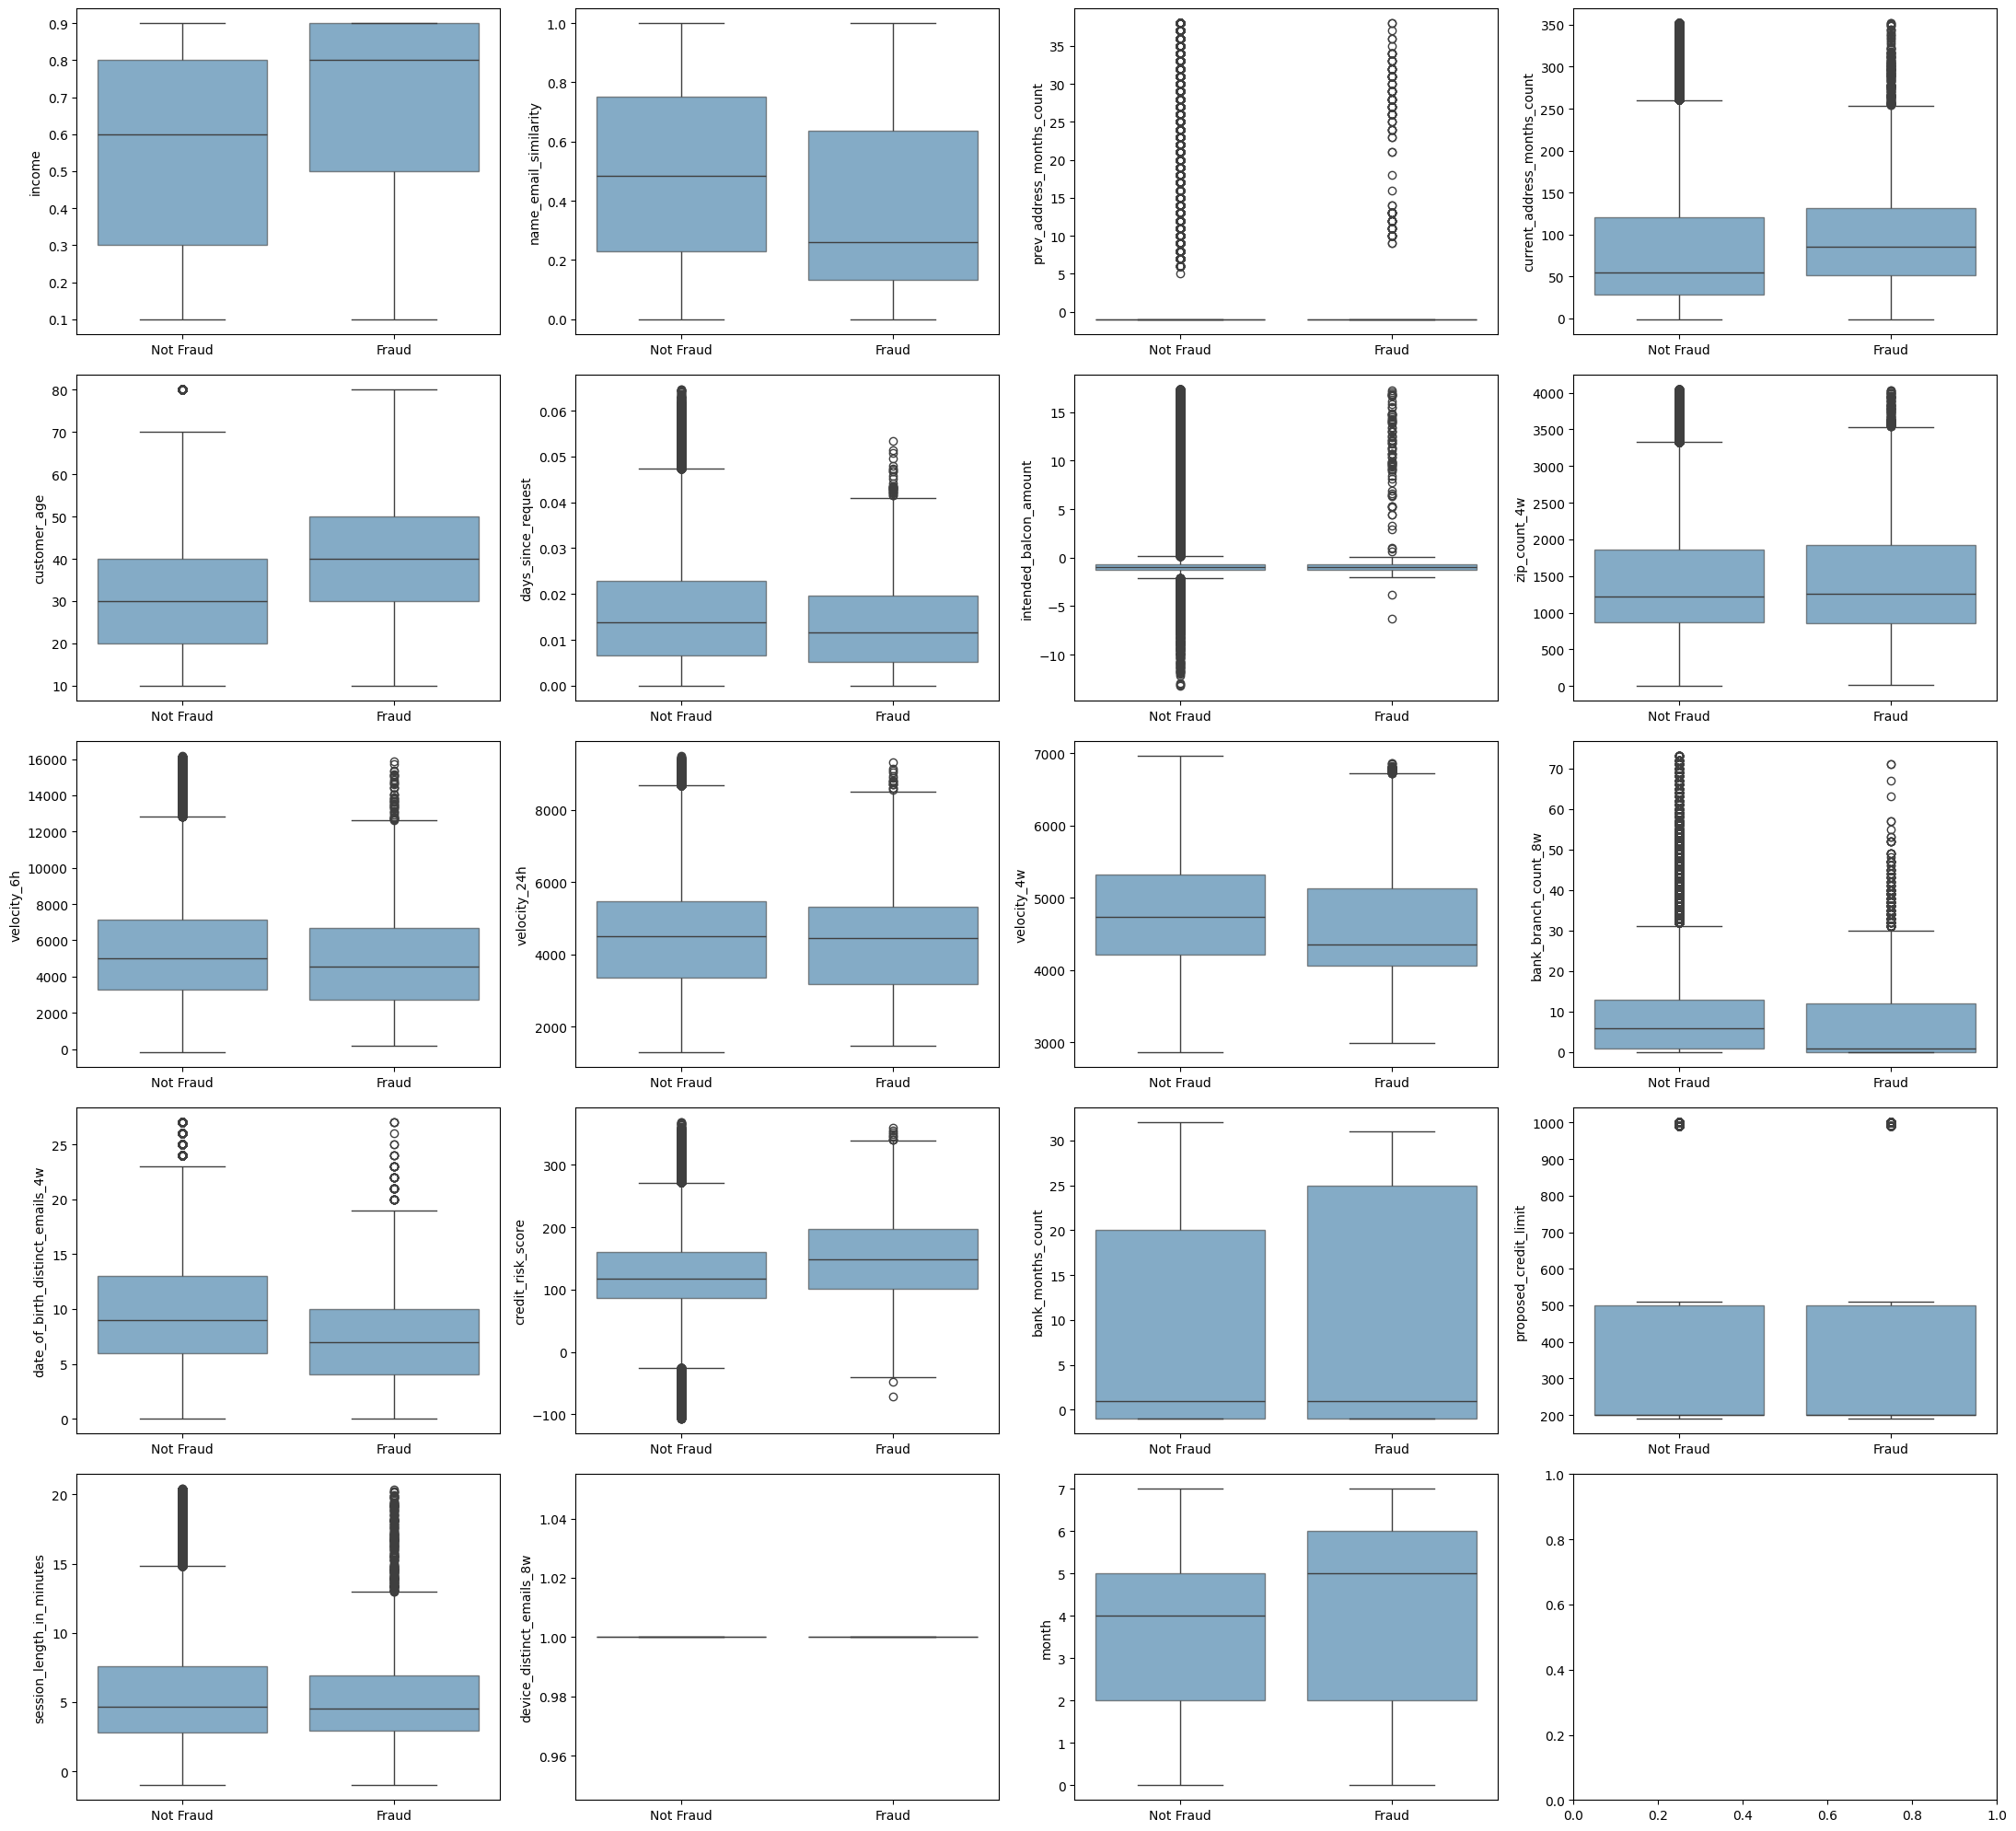

In [14]:
bivariante_boxplot_numerical(data_without_outliers[numerical_columns+[target_var]],target_var)

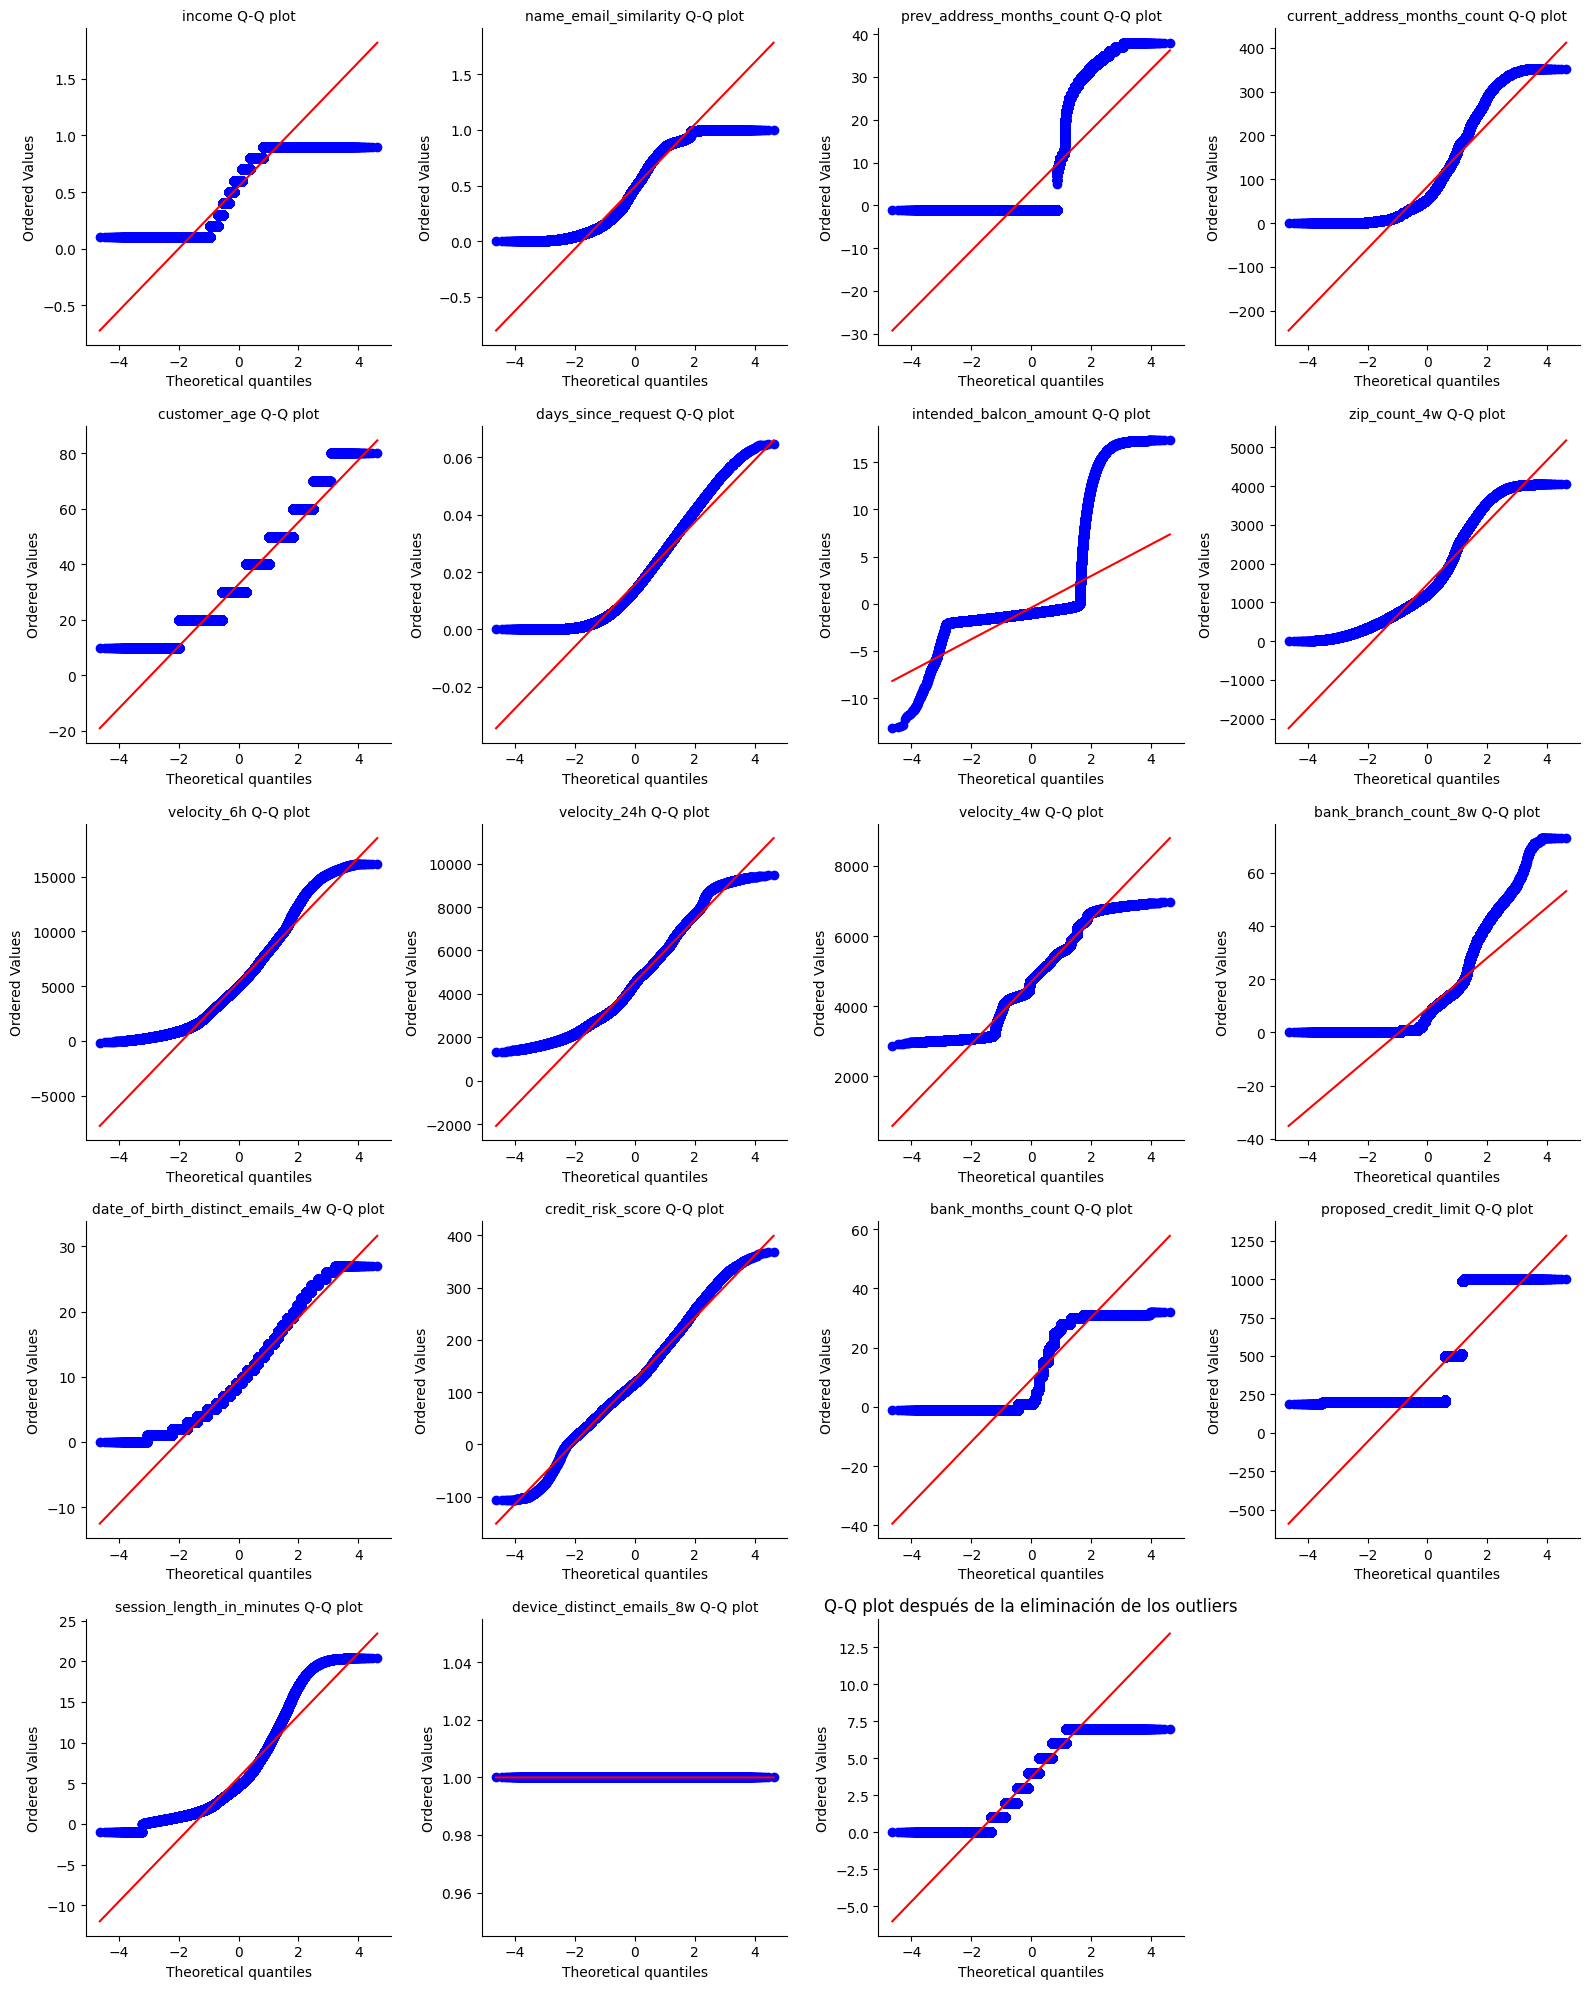

In [15]:
def check_normality(features, data_frame):
    num_features = len(features)
    cols = 4  
    rows = int(np.ceil(num_features / cols)) 
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Ajustamos tamaño dinámicamente
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        stats.probplot(data_frame[feature], dist=stats.norm, plot=axes[i])
        axes[i].set_title(f'{feature} Q-Q plot', fontsize=10)
        sns.despine()
    
    # Ocultar gráficos vacíos si sobran espacios en la cuadrícula
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.title('Q-Q plot después de la eliminación de los outliers')
    plt.tight_layout()
    plt.show()

# Llamada a la función con tus datos
check_normality(numerical_columns, data_without_outliers)

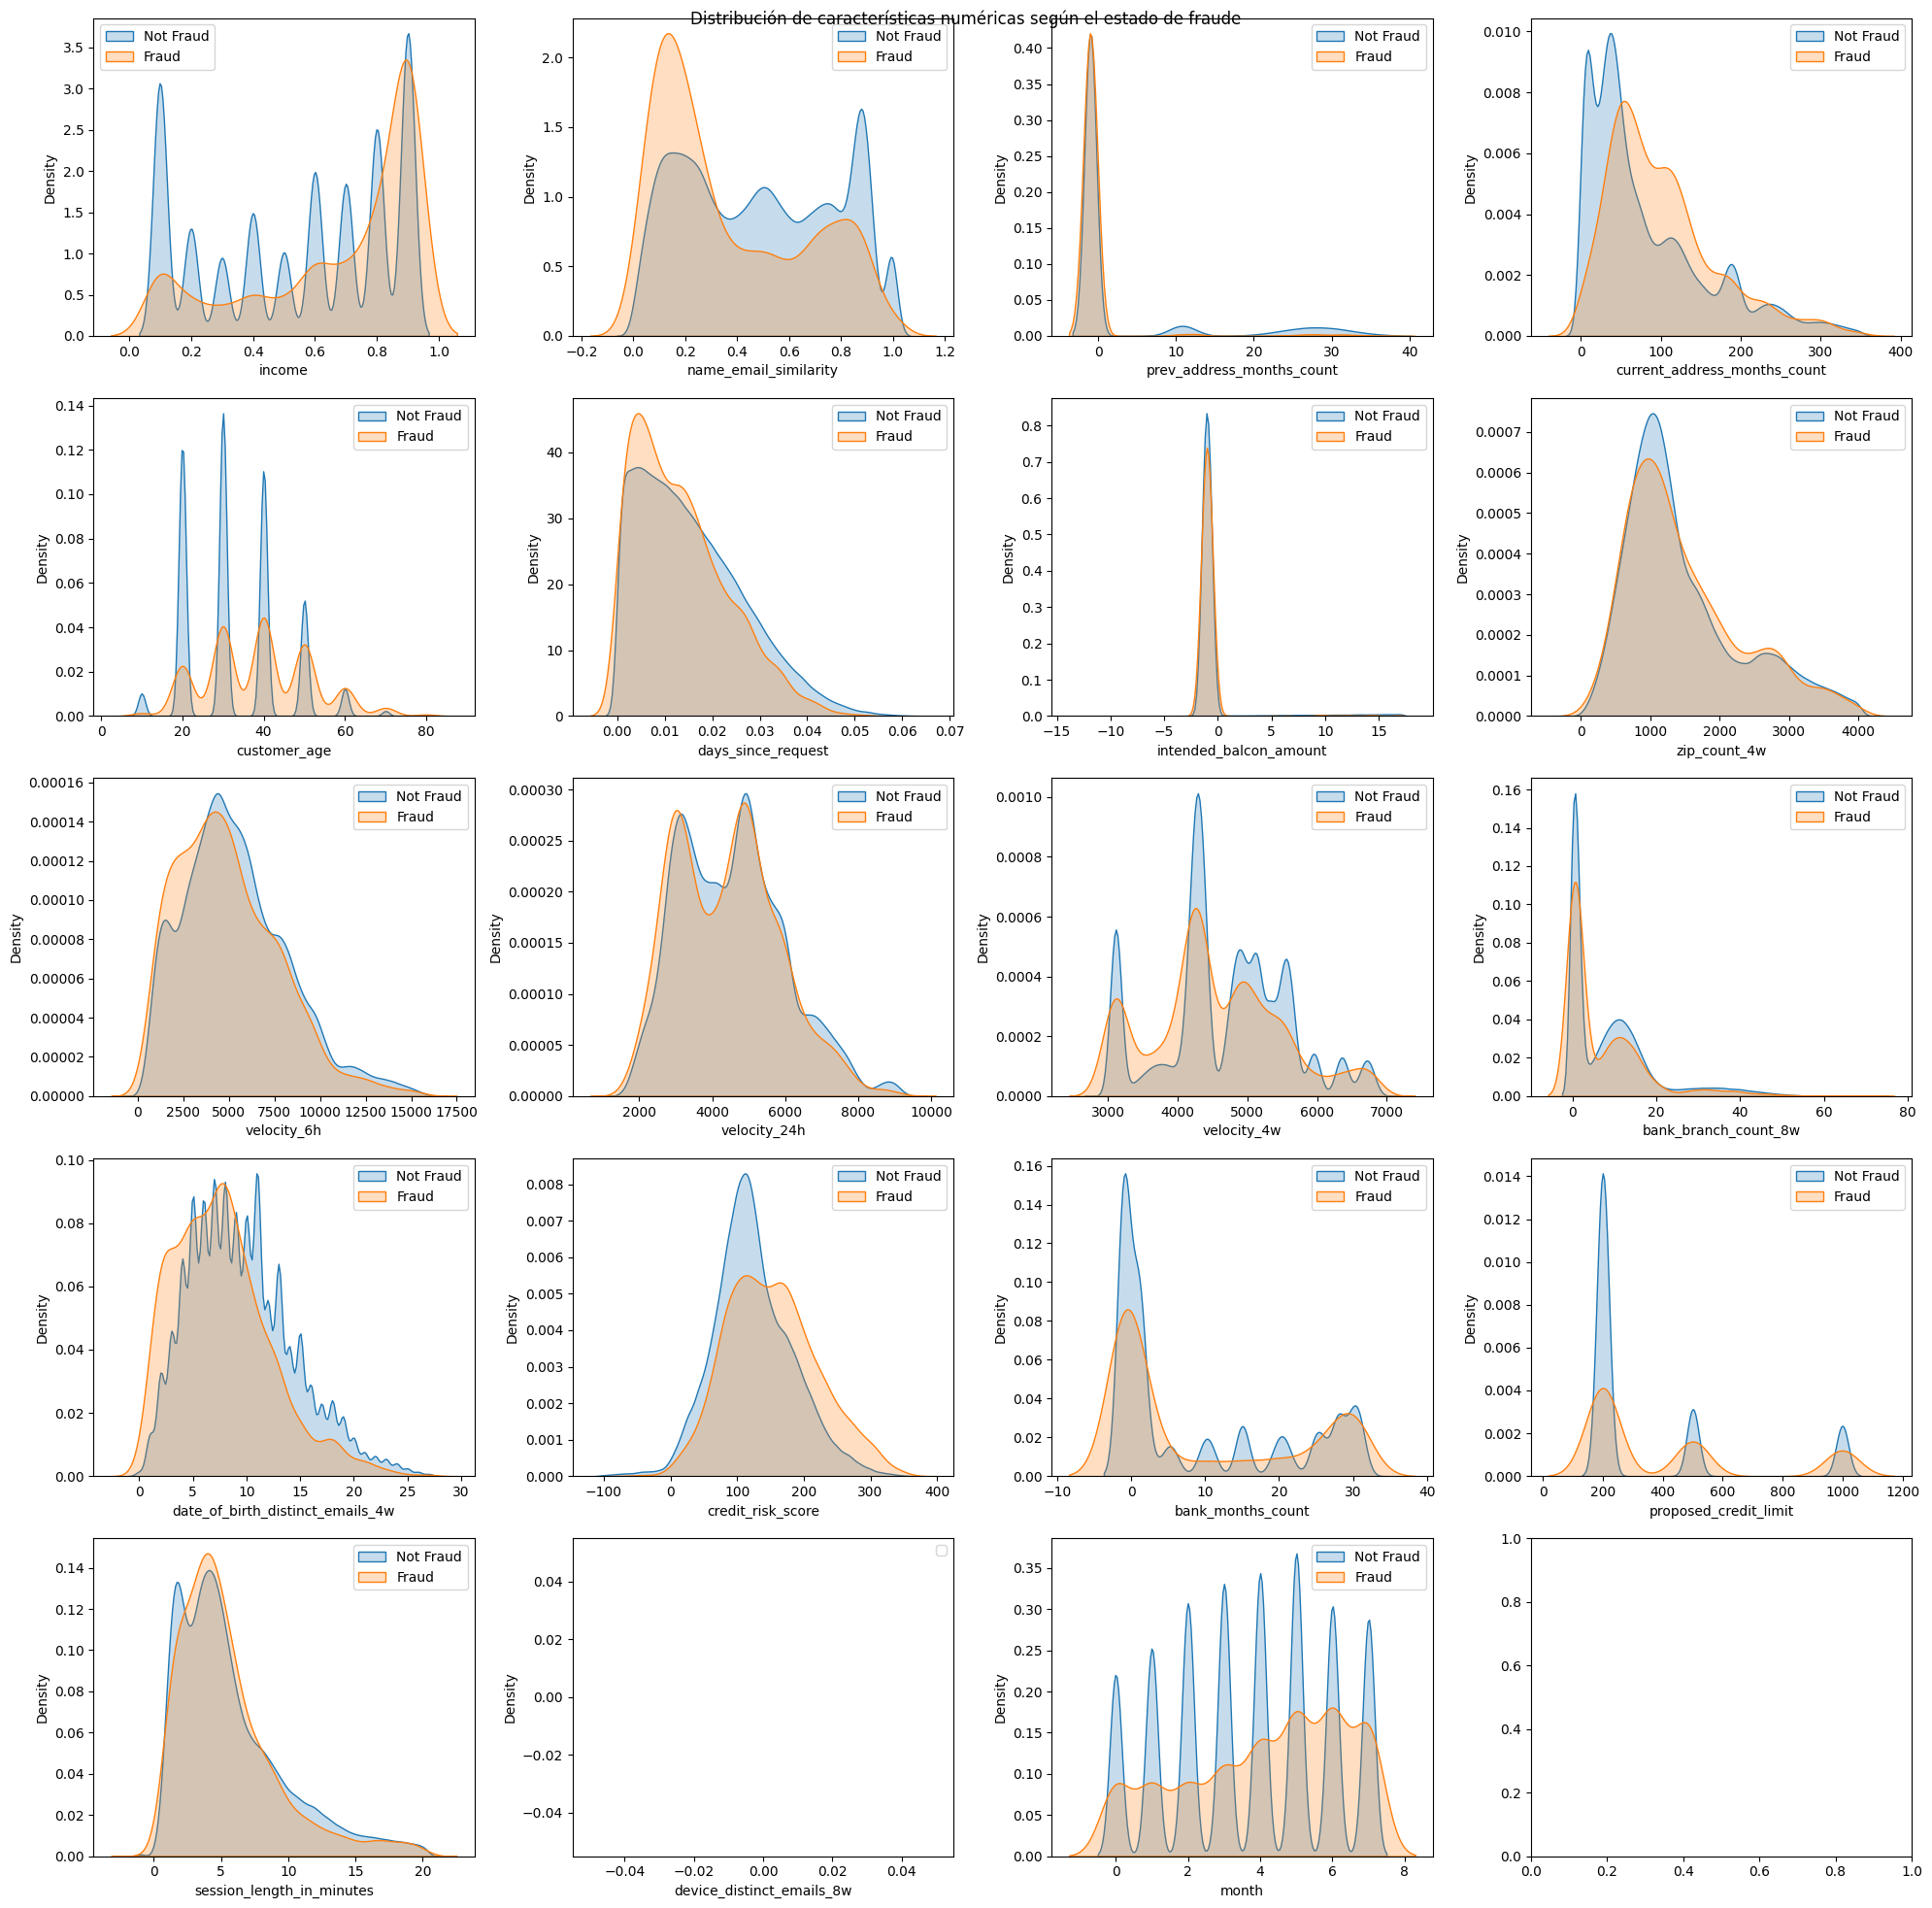

In [16]:
bivariante_graphs_numerical(data_without_outliers[numerical_columns+[target_var]],target_var)

##### Analisis de variables categoricas

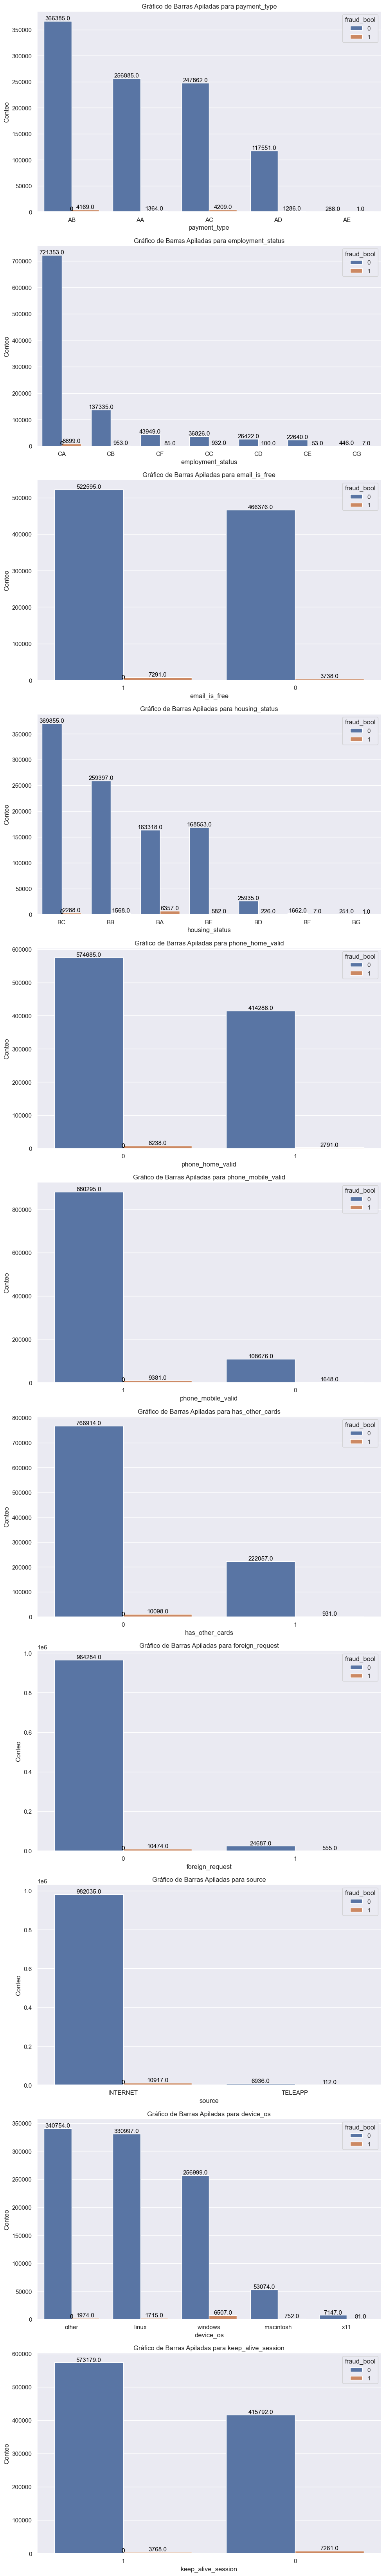

In [17]:
bivariante_graphs_categorial(data[categorical_columns], target_var)

##### Conclusión
Se toma el valor de `k=2` ya que es una buena opción al ofrecer un equilibrio entre la eliminación de outliers y la preservación de la clase moniritaria en el dataset desbalanceado.

## Codificación de variables

In [18]:
from sklearn.preprocessing import OneHotEncoder

### Codificación de las variables categoricas
Se codifican las variables categoticas para la selección de las variables con el objetivo de aplicar NearMiss, para ello se usa `OneHotEncoder` para variables categóricas sin orden (nominales), como colores, nombres de ciudades o tipos de productos. En estos casos, no hay una relación de mayor o menor entre las categorías.

In [19]:
categorical_features = [x for x in data_without_outliers.columns if data[x].dtypes == "O"]
categorical_features

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

In [20]:
data_encoding = data_without_outliers.copy()
# Inicializar OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, dtype=int)

# Aplicar OneHotEncoder
encoded_array = encoder.fit_transform(data_encoding[categorical_features])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features))
encoded_df

,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390927,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
390928,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
390929,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
390930,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


In [21]:
data_encoding.drop(columns=categorical_features, inplace=True)
data_encoding[encoded_df.columns] = encoded_df[encoded_df.columns]
data_encoding

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90,1,0,1,1,0,200.0,0,15.215816,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,0,0.8,0.153880,-1,103,40,0.045122,-1.101184,1548,4999.555801,4526.861667,6426.790817,6,7,163,0,1,1,25,1,200.0,0,11.234264,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,0.3,0.523655,21,2,30,0.035206,-0.955737,1781,6979.994002,4335.685346,6624.957942,2,10,35,0,1,0,2,0,200.0,0,5.329387,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,0,0.9,0.052615,-1,156,30,0.025660,-1.570164,1685,10282.430085,7499.069981,6785.368857,28,16,88,1,0,1,1,0,200.0,0,6.324050,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0,0.9,0.520718,-1,31,50,0.005729,-1.008223,597,2778.119599,6002.721890,6303.077748,12,26,80,1,0,1,10,0,200.0,0,3.731970,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390927,0,0.1,0.951756,-1,111,20,0.026208,-1.054070,430,7560.828680,3333.572279,3064.473608,8,6,105,0,1,1,11,0,200.0,0,2.205068,1,1,0,7,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
390928,0,0.1,0.736109,-1,59,40,0.003862,17.282748,816,4892.745269,3004.578021,3184.307293,6,3,97,1,1,1,20,0,200.0,0,1.643165,1,1,0,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
390929,0,0.9,0.375426,-1,287,30,0.008465,-0.840388,970,910.586499,3156.493443,3146.595806,14,4,181,1,1,1,15,1,200.0,0,0.959442,1,1,0,7,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
390930,0,0.9,0.824544,-1,193,30,0.009591,0.008307,408,1574.293294,2716.495767,4286.089050,0,5,235,0,1,1,-1,1,1000.0,0,1.504109,0,1,0,7,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


### Codificación de las variables binarias
En este caso no es necesario realizar una conversión de variables binarias pues las variables ya estan convertidas en numericas en el propio dataset. 

##### Conclusión
Se han codificado las variables categoricas usando OneHotEncoder y en el caso de las variables binarias no es necesario realizar el proceso

## Normalización de los datos
Se normliza los datos para las variables de tipo númericas para realizar una selección de caracteristicas

In [22]:
from sklearn.preprocessing import RobustScaler

In [23]:
# Inicializar el RobustScaler
scaler = RobustScaler()
data_feature_selection = data_encoding.copy()
data_feature_selection[numerical_columns] = scaler.fit_transform(data_feature_selection[numerical_columns])
data_feature_selection

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.0,-0.014376,12.0,-0.440860,0.0,-0.419194,-1.499403,2.302846,2.465427,1.054149,1.119867,0.416667,0.571429,-0.378378,1,0,1,0.000000,0,0.000000,0,2.186082,1,0.0,0,-1.333333,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,0,0.4,-0.625688,0.0,0.516129,0.5,1.924887,-0.171485,0.336382,-0.002827,0.005856,1.534536,0.000000,-0.285714,0.608108,0,1,1,1.142857,1,0.000000,0,1.360371,1,0.0,0,-1.333333,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,-0.6,0.078028,22.0,-0.569892,0.0,1.315298,0.082010,0.573171,0.515408,-0.084075,1.714563,-0.333333,0.142857,-1.121622,0,1,0,0.047619,0,0.000000,0,0.135791,1,0.0,0,-1.333333,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,0,0.6,-0.818406,0.0,1.086022,0.0,0.728459,-0.988854,0.475610,1.379581,1.404002,1.860289,1.833333,1.000000,-0.405405,1,0,1,0.000000,0,0.000000,0,0.342069,1,0.0,0,-1.333333,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0,0.6,0.072440,0.0,-0.258065,1.0,-0.496740,-0.009466,-0.630081,-0.584126,0.700110,1.422148,0.500000,2.428571,-0.513514,1,0,1,0.428571,0,0.000000,0,-0.195488,1,0.0,0,-1.333333,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390927,0,-1.0,0.892746,0.0,0.602151,-0.5,0.762151,-0.089370,-0.799797,0.667400,-0.555476,-1.519989,0.166667,-0.428571,-0.175676,0,1,1,0.476190,0,0.000000,0,-0.512144,1,0.0,0,1.000000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
390928,0,-1.0,0.482349,0.0,0.043011,0.5,-0.611559,31.869261,-0.407520,-0.030777,-0.710237,-1.411125,0.000000,-0.857143,-0.283784,1,1,1,0.904762,0,0.000000,0,-0.628673,1,0.0,0,1.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
390929,0,0.6,-0.204065,0.0,2.494624,0.0,-0.328569,0.283049,-0.251016,-1.072817,-0.638775,-1.445384,0.666667,-0.714286,0.851351,1,1,1,0.666667,1,0.000000,0,-0.770467,1,0.0,0,1.000000,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
390930,0,0.6,0.650650,0.0,1.483871,0.0,-0.259359,1.762211,-0.822154,-0.899140,-0.845752,-0.410202,-0.500000,-0.571429,1.581081,0,1,1,-0.095238,1,2.666667,0,-0.657512,0,0.0,0,1.000000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


## Selección de caracteristicas
Se realiza los test estadisticos para las diferentes variables con el objetivo de medir la relación entre las variables categoricas y numericas respecto a la variable objetivo.

### Eliminación de caracteristicas
La caracteristica que no posee variación en su valor y permanece constantes con un valor de 0 es la variable device_fraud_count por lo que se va a eliminar debido a que no aporta nada en el analisis

In [24]:
data_feature_selection['device_distinct_emails_8w'].value_counts()

device_distinct_emails_8w
0.0    390932
Name: count, dtype: int64

In [25]:
data_feature_selection['device_fraud_count'].value_counts()

device_fraud_count
0    390932
Name: count, dtype: int64

In [26]:
data_feature_selection.drop(columns = ["device_fraud_count","device_distinct_emails_8w"], axis=1, inplace=True)

### Remuestreo para la efectiva selección de caracteristicas
Para lograr el remuestres se usa NearMiss que es una técnica de submuestreo (undersampling) utilizada para balancear clases desbalanceadas en un dataset. A diferencia de SMOTE, que aumenta la cantidad de muestras de la clase minoritaria, NearMiss reduce la cantidad de muestras de la clase mayoritaria eliminando datos estratégicamente.


In [27]:
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.feature_selection import SelectFromModel

#### Remuestreo de los datos
Se realiza el remuestreo de los datos usando NearMiss para equilibrar el dataset antes de la selección de características.

In [28]:
print(f'Dataset antes del remuestreo {Counter(data_feature_selection[target_var])}')
data_feature_selection_ = data_feature_selection.copy()
nm = NearMiss(sampling_strategy=1, n_jobs=-1)
x_scaled_feature, y_scaled_feature = nm.fit_resample(data_feature_selection_, data_feature_selection_[target_var])
x_scaled_feature.drop("fraud_bool", axis=1, inplace=True)
print('Dataset después del remuestreo %s' % Counter(y_scaled_feature))

x_scaled_feature

Dataset antes del remuestreo Counter({0: 387288, 1: 3644})


  File "c:\Users\jonat\Desktop\FraudDetectAI\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\jonat\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jonat\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^

Dataset después del remuestreo Counter({0: 3644, 1: 3644})


,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.6,-0.159374,0.0,0.193548,0.0,-0.034646,-0.468846,-0.628049,-0.382030,-1.180529,-1.348988,-0.500000,0.142857,-0.229730,0,0,1,-0.095238,0,0.0,0,0.052247,1,1.000000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0.6,-0.385622,0.0,0.505376,0.0,0.160404,0.157707,-0.519309,-0.310701,-0.595990,-1.481390,-0.416667,-0.285714,-0.391892,1,0,1,-0.095238,0,0.0,0,-0.759828,1,1.000000,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,0.6,-0.366051,0.0,0.440860,1.0,-0.802689,-0.263120,-0.386179,-0.100814,0.100328,-0.310026,-0.416667,-0.571429,1.675676,1,0,1,-0.095238,0,0.0,0,-0.436255,0,0.666667,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0.0,-0.766089,0.0,0.430108,0.5,0.134998,0.334995,-0.308943,-0.159241,-0.735909,-1.443073,-0.416667,-0.285714,-0.270270,1,0,1,-0.095238,0,0.0,0,-0.629231,1,1.000000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0.4,-0.498496,0.0,0.129032,0.0,-0.135922,-0.275352,-0.581301,-0.139404,-0.591789,-0.694191,-0.333333,-0.142857,-0.472973,1,0,1,-0.095238,0,0.0,0,0.735111,0,0.666667,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7283,0.6,0.058253,0.0,0.118280,0.5,-0.037535,0.962524,-0.497967,-0.780873,-0.794633,-1.470805,0.000000,-0.714286,2.000000,0,0,1,1.428571,0,1.0,0,-0.008450,0,1.000000,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
7284,0.4,0.027263,0.0,-0.129032,1.0,-0.739787,1.466312,-0.429878,-0.787048,-1.163926,-1.429628,2.416667,-0.571429,-0.270270,0,1,1,0.190476,0,1.0,0,-0.340876,0,1.000000,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
7285,0.6,0.797129,12.0,0.451613,0.0,-0.257749,0.059729,0.694106,-1.000182,-0.410826,0.744426,-0.416667,0.428571,1.418919,0,0,1,-0.095238,0,0.0,0,-0.582933,0,1.000000,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
7286,0.6,0.729840,0.0,1.774194,1.0,1.074407,-0.001391,0.383130,0.216083,-0.665096,-1.502460,-0.416667,-0.142857,1.162162,1,0,1,-0.095238,0,1.0,1,0.605834,0,1.000000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


### Eliminar caracteristicas altamente correlacionadas
Se analizan todas las caracteristicas para eliminar aquellas que estan fuertemente correlacionadas

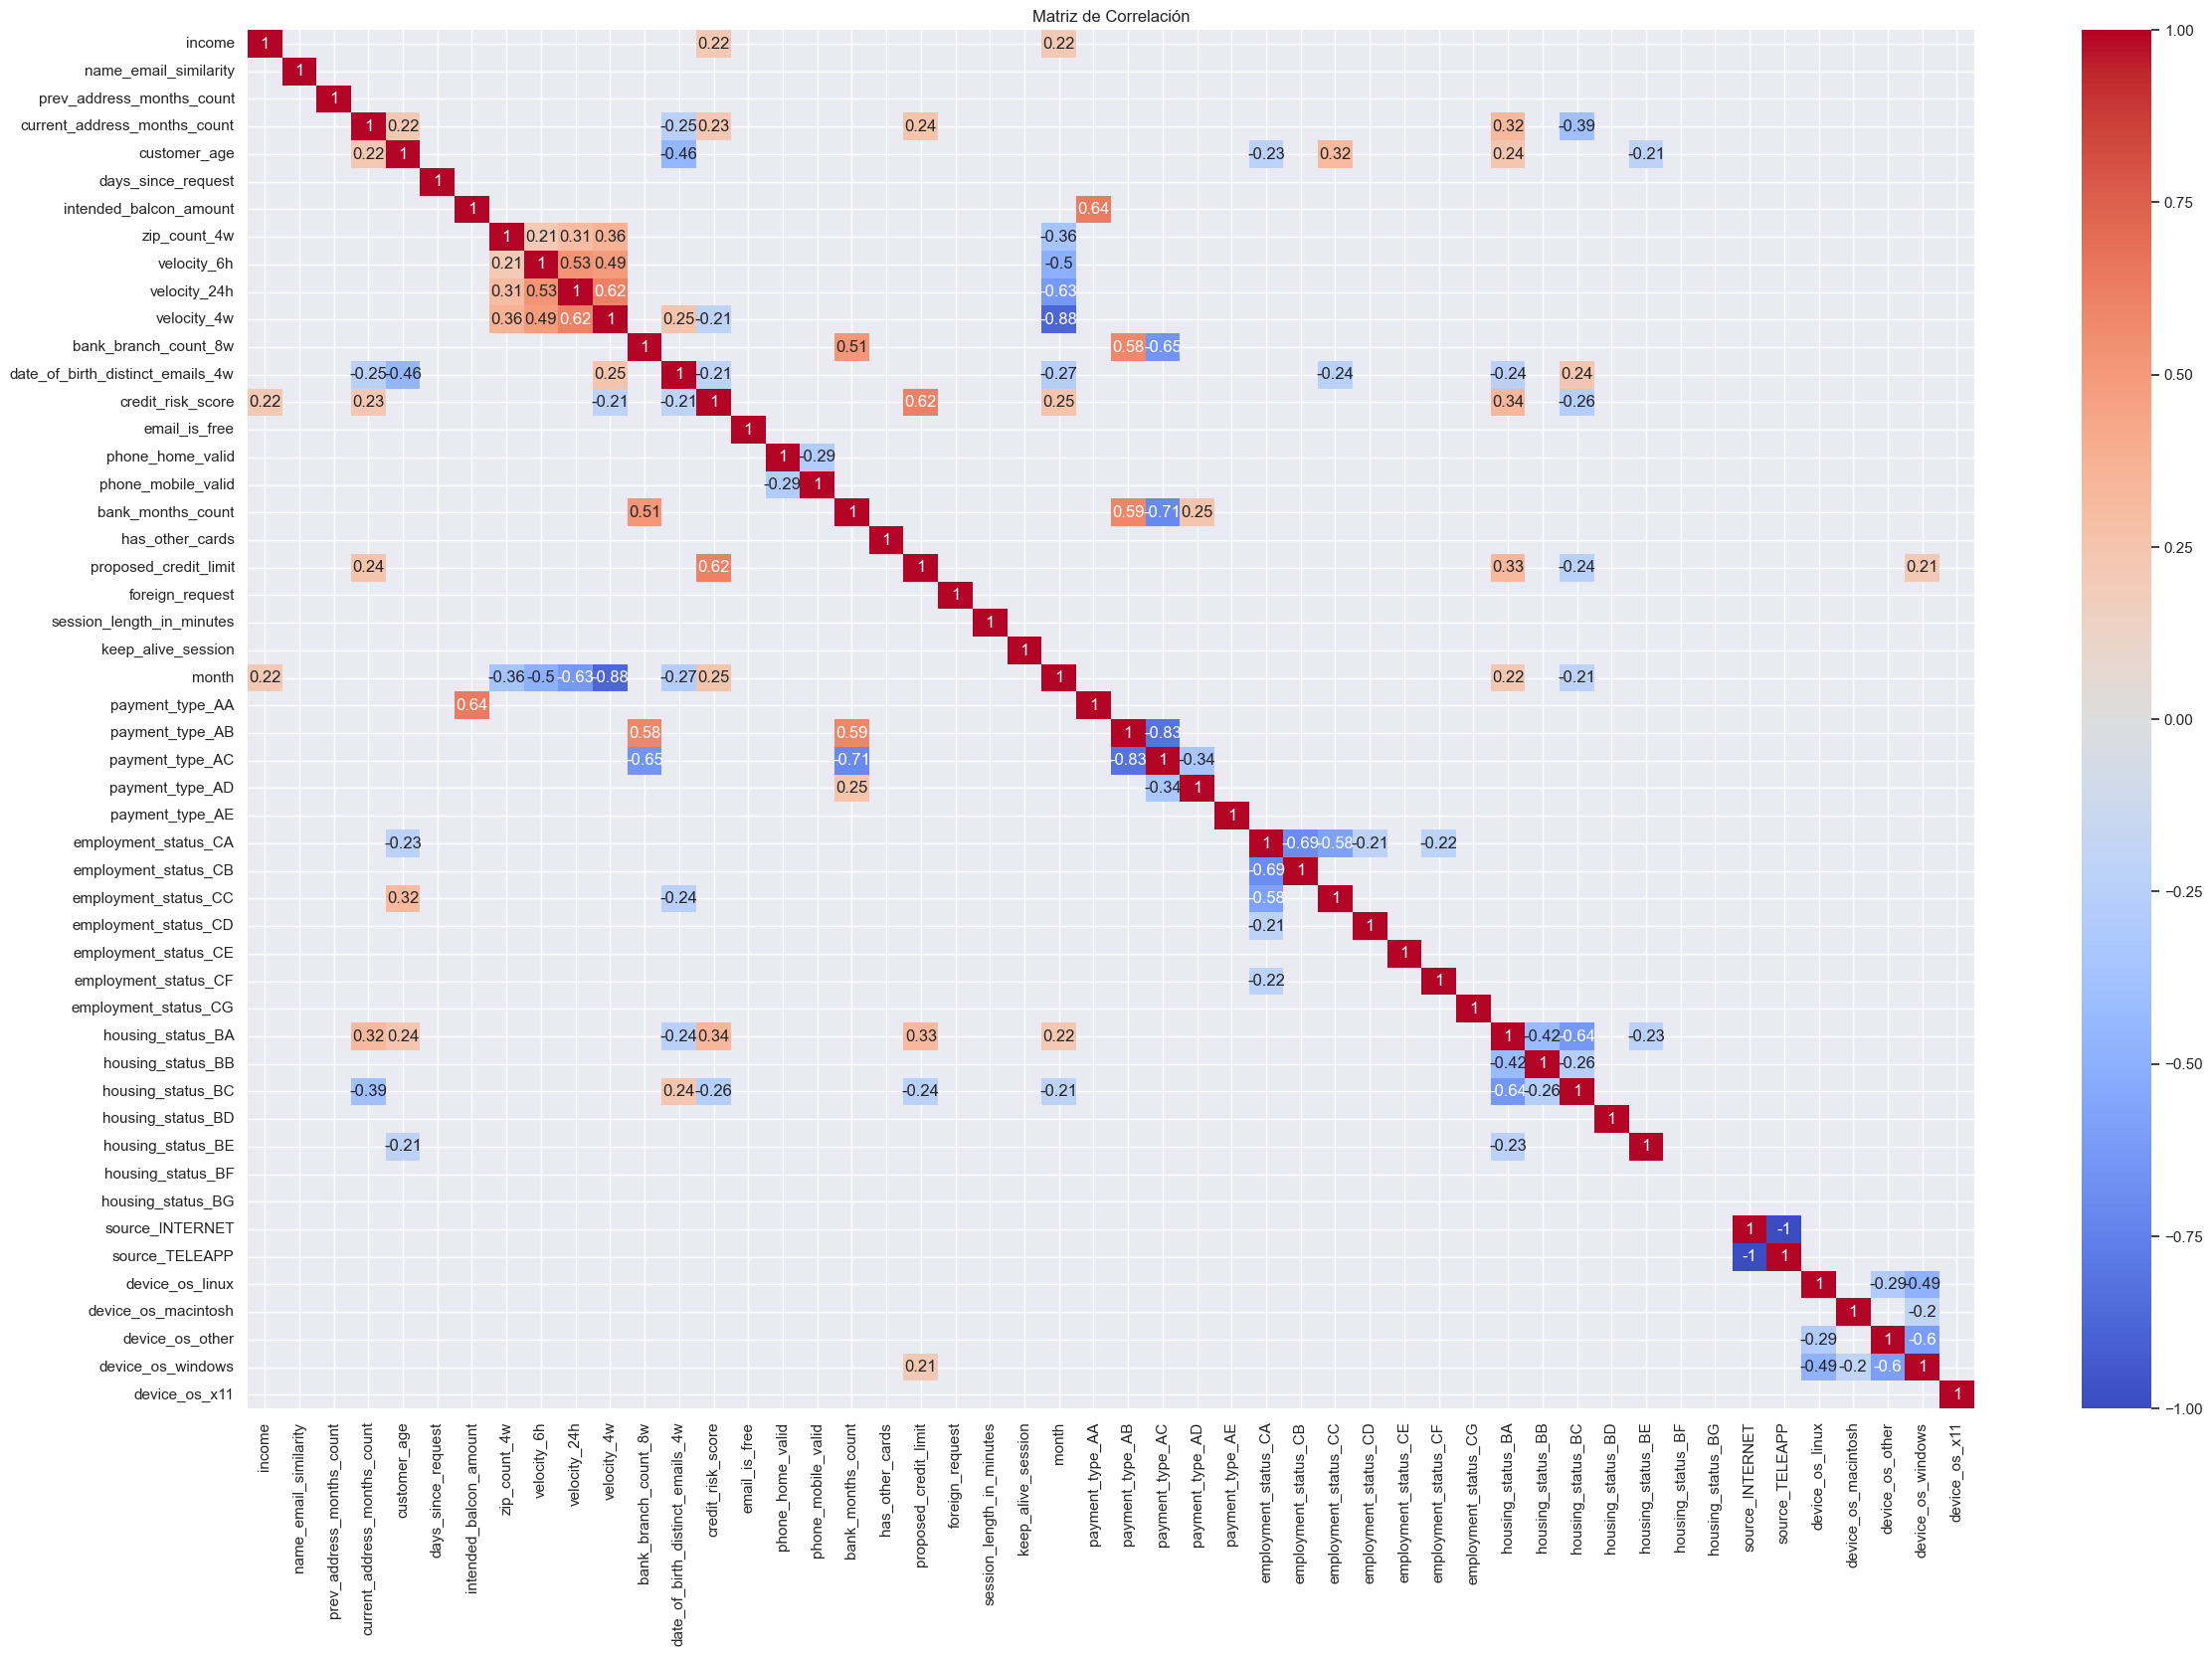

In [29]:
matriz_correlacion = x_scaled_feature.corr()
# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(28, 18))
sns.heatmap(matriz_correlacion[(matriz_correlacion >= 0.2) | (matriz_correlacion <= -0.2)], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

In [30]:
# Function to drop correlated features
def correlation(dataset, threshold):
    col_corr = set ()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if  (corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features_delete = correlation(x_scaled_feature, 0.7)
print(corr_features_delete)

set()


In [31]:
if corr_features_delete is not None:
    x_scaled_feature.drop(corr_features_delete, axis=1,inplace=True)

x_scaled_feature

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.6,-0.159374,0.0,0.193548,0.0,-0.034646,-0.468846,-0.628049,-0.382030,-1.180529,-1.348988,-0.500000,0.142857,-0.229730,0,0,1,-0.095238,0,0.0,0,0.052247,1,1.000000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0.6,-0.385622,0.0,0.505376,0.0,0.160404,0.157707,-0.519309,-0.310701,-0.595990,-1.481390,-0.416667,-0.285714,-0.391892,1,0,1,-0.095238,0,0.0,0,-0.759828,1,1.000000,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,0.6,-0.366051,0.0,0.440860,1.0,-0.802689,-0.263120,-0.386179,-0.100814,0.100328,-0.310026,-0.416667,-0.571429,1.675676,1,0,1,-0.095238,0,0.0,0,-0.436255,0,0.666667,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0.0,-0.766089,0.0,0.430108,0.5,0.134998,0.334995,-0.308943,-0.159241,-0.735909,-1.443073,-0.416667,-0.285714,-0.270270,1,0,1,-0.095238,0,0.0,0,-0.629231,1,1.000000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0.4,-0.498496,0.0,0.129032,0.0,-0.135922,-0.275352,-0.581301,-0.139404,-0.591789,-0.694191,-0.333333,-0.142857,-0.472973,1,0,1,-0.095238,0,0.0,0,0.735111,0,0.666667,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7283,0.6,0.058253,0.0,0.118280,0.5,-0.037535,0.962524,-0.497967,-0.780873,-0.794633,-1.470805,0.000000,-0.714286,2.000000,0,0,1,1.428571,0,1.0,0,-0.008450,0,1.000000,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
7284,0.4,0.027263,0.0,-0.129032,1.0,-0.739787,1.466312,-0.429878,-0.787048,-1.163926,-1.429628,2.416667,-0.571429,-0.270270,0,1,1,0.190476,0,1.0,0,-0.340876,0,1.000000,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
7285,0.6,0.797129,12.0,0.451613,0.0,-0.257749,0.059729,0.694106,-1.000182,-0.410826,0.744426,-0.416667,0.428571,1.418919,0,0,1,-0.095238,0,0.0,0,-0.582933,0,1.000000,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
7286,0.6,0.729840,0.0,1.774194,1.0,1.074407,-0.001391,0.383130,0.216083,-0.665096,-1.502460,-0.416667,-0.142857,1.162162,1,0,1,-0.095238,0,1.0,1,0.605834,0,1.000000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


#####   Conclusión
Se eliminan las variables que tienen una alta correlación entre ellas por lo que se elimina la variable `proposed_credit_limit`, `payment_type_AA`

### Asociación de variables binarias
**H0**: La variable categórica no está asociada.\
**H1**: La variable categórica está asociada con la variable objetivo.\
Variables categoricas con solo dos categoricas: email_is_free, phone_home_valid, phone_mobile_valid, has_other_cards, foreign_request, keep_alive_session

Para este analisis se ocupa la prueba estadistica de Fisher, utilizado para determinar si existe una asociación significativa entre dos variables categóricas. Es útil cuando se trabaja con muestras pequeñas o cuando se desea una precisión extrema en el cálculo de los valores de significancia.

In [32]:
result_analysis_binary = []
def prueba_fisher(tabla):
    var_analysis = {}
    odds_ratio, p_valor = fisher_exact(tabla)
    var_analysis['Variable'] = variable
    var_analysis['Valor p'] = p_valor

    if p_valor < 0.05:
        var_analysis['Analisis p_valor'] = "Existe una asociación significativa entre las variables."
    else:
        var_analysis['Analisis p_valor'] = "No hay suficiente evidencia para afirmar que las variables están asociadas."

    var_analysis['Odds Ratio'] = odds_ratio
    if odds_ratio > 1:
        var_analysis['Analisis odds_ratio'] = "El evento es más probable en el variable de analisis."
    elif odds_ratio < 1:
        var_analysis['Analisis odds_ratio'] = "El evento es más probable en la variable objetivo."
    else:
        var_analysis['Analisis odds_ratio'] = "No hay diferencia en la probabilidad del evento entre los grupos."

    return var_analysis


categorical_columns_bivar = set(x_scaled_feature.columns)-set(numerical_columns)

for variable in categorical_columns_bivar:
    contingency_table = pd.crosstab(x_scaled_feature[variable], y_scaled_feature)
    result_analysis_binary.append(prueba_fisher(contingency_table))

data_analysis_binary = pd.DataFrame(result_analysis_binary)
data_analysis_binary.sort_values(by='Odds Ratio',inplace=True)
data_analysis_binary

,Variable,Valor p,Analisis p_valor,Odds Ratio,Analisis odds_ratio
19,source_INTERNET,1.419801e-08,Existe una asociación significativa entre las variables.,0.000000,El evento es más probable en la variable objetivo.
11,employment_status_CA,1.551802e-156,Existe una asociación significativa entre las variables.,0.058393,El evento es más probable en la variable objetivo.
30,phone_mobile_valid,1.210880e-85,Existe una asociación significativa entre las variables.,0.108906,El evento es más probable en la variable objetivo.
14,payment_type_AC,2.214998e-297,Existe una asociación significativa entre las variables.,0.145528,El evento es más probable en la variable objetivo.
4,device_os_other,9.748667e-33,Existe una asociación significativa entre las variables.,0.526566,El evento es más probable en la variable objetivo.
2,keep_alive_session,1.738646e-27,Existe una asociación significativa entre las variables.,0.596435,El evento es más probable en la variable objetivo.
20,housing_status_BC,2.845754e-17,Existe una asociación significativa entre las variables.,0.642447,El evento es más probable en la variable objetivo.
21,device_os_linux,8.972893e-06,Existe una asociación significativa entre las variables.,0.767127,El evento es más probable en la variable objetivo.
7,housing_status_BA,6.732181e-01,No hay suficiente evidencia para afirmar que las variables están asociadas.,0.979355,El evento es más probable en la variable objetivo.
12,housing_status_BF,1.000000e+00,No hay suficiente evidencia para afirmar que las variables están asociadas.,1.000000,No hay diferencia en la probabilidad del evento entre los grupos.


In [33]:
#Variables con Odd Ratio > 1
data_analysis_binary[data_analysis_binary['Odds Ratio']>1]
data_analysis_binary['Variable']

19         source_INTERNET
11    employment_status_CA
30      phone_mobile_valid
14         payment_type_AC
4          device_os_other
2       keep_alive_session
20       housing_status_BC
21         device_os_linux
7        housing_status_BA
12       housing_status_BF
5        housing_status_BG
24           email_is_free
16       housing_status_BB
28         has_other_cards
10       device_os_windows
0         phone_home_valid
17       housing_status_BE
1          payment_type_AB
23     device_os_macintosh
27    employment_status_CB
3        housing_status_BD
22         foreign_request
9     employment_status_CF
15         payment_type_AD
8     employment_status_CC
6          payment_type_AE
13         payment_type_AA
18    employment_status_CD
26    employment_status_CG
25          source_TELEAPP
29    employment_status_CE
31           device_os_x11
Name: Variable, dtype: object

In [34]:
#Se filtran los valores de Odds Ratio con valores > 1 lo que representa a medida que la variable aumenta, la probabilidad de que ocurra el evento aumenta; 
#adicionalemente se eliminan los datos con fuerte asociación pero pueden dar paso a un posible overfitting en el modelo
data_analysis_binary_ = data_analysis_binary.copy()
data_analysis_binary_ = data_analysis_binary_[(data_analysis_binary_['Odds Ratio']>1) & (data_analysis_binary_['Valor p']<0.05)]
# Reemplazar los valores infinitos por NaN
data_analysis_binary_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar las filas con NaN
data_analysis_binary_.dropna(inplace=True)
data_analysis_binary_.sort_values(by='Odds Ratio',inplace=True)
data_analysis_binary_.reset_index(drop=True,inplace=True)
data_analysis_binary_

,Variable,Valor p,Analisis p_valor,Odds Ratio,Analisis odds_ratio
0,housing_status_BB,4.776324e-04,Existe una asociación significativa entre las variables.,1.262050,El evento es más probable en el variable de analisis.
1,has_other_cards,3.485407e-04,Existe una asociación significativa entre las variables.,1.443750,El evento es más probable en el variable de analisis.
2,device_os_windows,3.154635e-17,Existe una asociación significativa entre las variables.,1.488208,El evento es más probable en el variable de analisis.
3,phone_home_valid,5.490535e-20,Existe una asociación significativa entre las variables.,1.723169,El evento es más probable en el variable de analisis.
4,housing_status_BE,9.462832e-20,Existe una asociación significativa entre las variables.,2.897248,El evento es más probable en el variable de analisis.
5,payment_type_AB,2.649219e-130,Existe una asociación significativa entre las variables.,3.762154,El evento es más probable en el variable de analisis.
6,device_os_macintosh,3.811824e-44,Existe una asociación significativa entre las variables.,8.094749,El evento es más probable en el variable de analisis.
7,employment_status_CB,1.066072e-57,Existe una asociación significativa entre las variables.,8.517981,El evento es más probable en el variable de analisis.
8,housing_status_BD,9.003966e-18,Existe una asociación significativa entre las variables.,13.610176,El evento es más probable en el variable de analisis.
9,foreign_request,1.020382e-38,Existe una asociación significativa entre las variables.,19.033844,El evento es más probable en el variable de analisis.


##### Conclusion
**Valor p**: Todas las variables tienen un valor p menor que 0.05, excepto las variables con `housing_status_BA`, `housing_status_BF`, `housing_status_BG`, `email_is_free`, `employment_status_CG` y `payment_type_AE` por lo tanto, para esas variables se tiene la hipotesis nula. Adicional para el resto de variables rechazamos la hipótesis nula y afirmamos que hay una asociación de estas variables con la variable objetivo.

**Razón de probabilidades (odds ratio)**: 
Las variables `source_INTERNET`, `employment_status_CA`, `phone_mobile_valid`, `payment_type_AC`, `device_os_other`, `keep_alive_session`, `housing_status_BC`, `device_os_linux`, `housing_status_BA`, `housing_status_BF`, `housing_status_BG`, `email_is_free`, `housing_status_BB`, `has_other_cards`, `device_os_windows`, `phone_home_valid`, `housing_status_BE`, `payment_type_AB`, `device_os_macintosh`, `employment_status_CB`, `housing_status_BD`, `foreign_request`, `employment_status_CF`, `payment_type_AD`, `employment_status_CC`, `employment_status_CD`, `employment_status_CG`, `employment_status_CE`, `device_os_x11`, `payment_type_AE`, `source_TELEAPP` y `payment_type_AA`, tienen una razón de probabilidades mayor que 1, por lo tanto, podemos concluir que están asociadas positivamente con el evento objetivo (fraud_bool).

Finalmente con los resultados anteriores se toman las variables `housing_status_BB`, `has_other_cards`, `device_os_windows`, `phone_home_valid`, `housing_status_BE`, `payment_type_AB`, `device_os_macintosh`, `employment_status_CB`, `housing_status_BD`, `foreign_request`, `employment_status_CF`, `payment_type_AD` y `employment_status_CC` que cumplen ambos criterios por ser valores más significativo para el modelo.

In [35]:
binary_preselected_variables =  data_analysis_binary_['Variable'].to_list()

### Analisis de la correlación en variables númericas

Una matriz de correlación es una tabla que muestra los coeficientes de correlación entre varias variables. Cada celda de la tabla muestra el valor de la correlación entre dos variables diferentes. Los coeficientes de correlación pueden variar entre -1 y 1, donde:

1: indica una correlación positiva perfecta. \
-1: indica una correlación negativa perfecta. \
0: indica que no hay correlación.

In [36]:
numerical_columns_corr = ['income','name_email_similarity','prev_address_months_count','current_address_months_count','customer_age','days_since_request','intended_balcon_amount','zip_count_4w','velocity_6h','velocity_24h','velocity_4w','bank_branch_count_8w','date_of_birth_distinct_emails_4w','credit_risk_score','bank_months_count','session_length_in_minutes','month']

In [37]:
matriz_correlacion = x_scaled_feature[numerical_columns_corr].corr()
matriz_correlacion

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,session_length_in_minutes,month
income,1.000000,-0.033992,0.006233,0.019403,0.085418,-0.010640,0.001715,-0.109302,-0.139880,-0.180158,-0.199105,0.005102,-0.109570,0.215343,-0.007484,-0.097101,0.218290
name_email_similarity,-0.033992,1.000000,-0.011413,0.045653,-0.021935,-0.011064,0.041947,0.023335,0.045055,0.038637,0.069007,-0.055165,0.045012,0.089384,-0.064249,0.037308,-0.088326
prev_address_months_count,0.006233,-0.011413,1.000000,-0.152157,-0.042289,0.005188,0.015716,-0.001727,0.023710,0.046260,0.024804,0.040408,0.063439,-0.005539,0.034640,0.048147,-0.035166
current_address_months_count,0.019403,0.045653,-0.152157,1.000000,0.221069,0.026198,0.036769,0.016924,-0.022480,0.008372,-0.016142,-0.002372,-0.247133,0.230713,0.030613,0.020625,0.040663
customer_age,0.085418,-0.021935,-0.042289,0.221069,1.000000,0.039848,0.003164,-0.017091,0.005341,0.056871,0.029731,0.037664,-0.455600,0.192636,0.048986,0.037870,-0.017755
days_since_request,-0.010640,-0.011064,0.005188,0.026198,0.039848,1.000000,-0.007689,-0.016869,0.035001,0.040583,0.025282,0.096453,-0.018960,0.010002,0.084293,0.048667,-0.021587
intended_balcon_amount,0.001715,0.041947,0.015716,0.036769,0.003164,-0.007689,1.000000,0.032847,0.054972,0.103268,0.071157,0.034615,0.017990,-0.000554,0.083131,0.069101,-0.056795
zip_count_4w,-0.109302,0.023335,-0.001727,0.016924,-0.017091,-0.016869,0.032847,1.000000,0.206933,0.309369,0.362269,0.049557,0.144357,-0.100385,0.074321,0.086870,-0.357315
velocity_6h,-0.139880,0.045055,0.023710,-0.022480,0.005341,0.035001,0.054972,0.206933,1.000000,0.526145,0.489044,0.039344,0.159812,-0.183970,0.030766,0.082641,-0.502971
velocity_24h,-0.180158,0.038637,0.046260,0.008372,0.056871,0.040583,0.103268,0.309369,0.526145,1.000000,0.616100,0.056310,0.169990,-0.197504,0.069680,0.130556,-0.629680


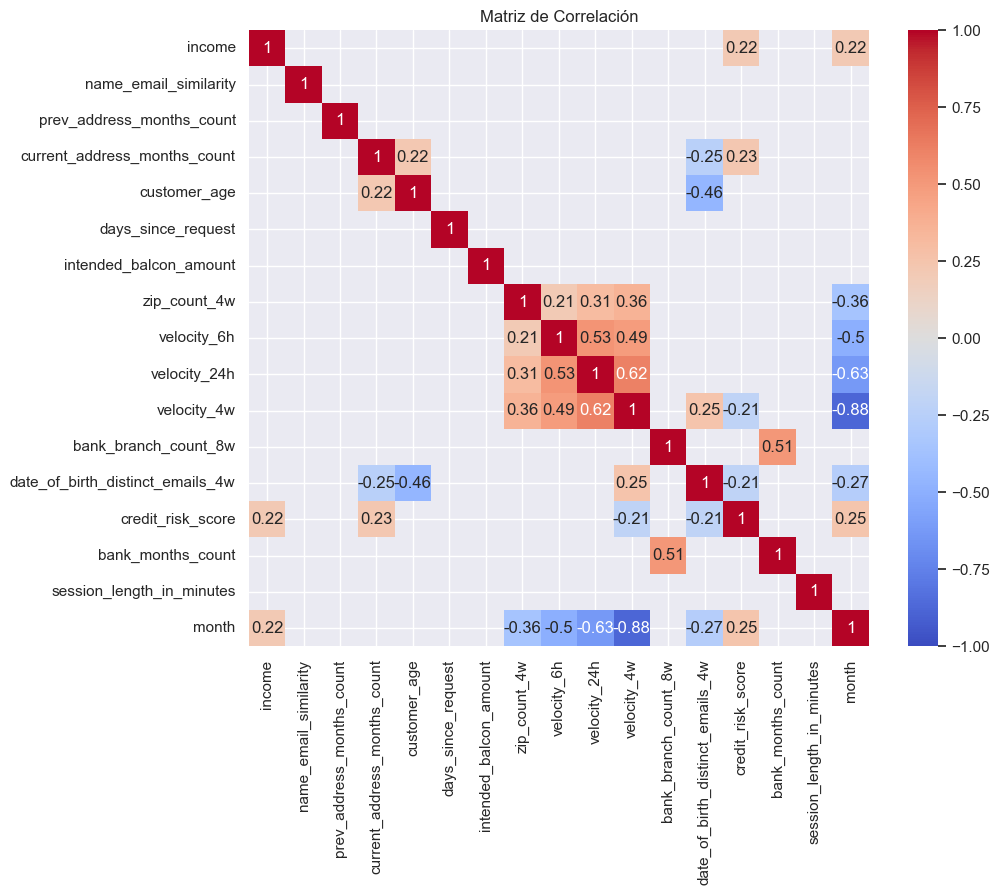

In [38]:
matriz_correlacion = x_scaled_feature[numerical_columns_corr].corr()
# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion[(matriz_correlacion >= 0.2) | (matriz_correlacion <= -0.2)], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

##### Conclusion
Se observa que las variables entre si no tienen valores altos en su correlación es decir correlación > 0.8 o < -0.8 entre ellas excepto por las varibales `month` y `velocity_4w` por lo que se va a hacer el analisis de multicolinealidad de las variables numericas antes de descarter una de ellas.

#### Analisis de la multicolinealidad de las variables numericas
Para evaluar las variables se usa VIF (Variance Inflation Factor) para evaluar la multicolinealidad en un modelo de regresión múltiple. La multicolinealidad ocurre cuando dos o más variables predictoras en un modelo están altamente correlacionadas entre sí, lo cual puede ser problemático porque puede llevar a coeficientes de regresión poco fiables y dificultar la interpretación de los efectos individuales de las variables predictoras. 

In [39]:
vif_data = x_scaled_feature[numerical_columns_corr]
#Agregando una columna constante para la intersección
X = sm.add_constant(vif_data)
# Calcula el VIF para cada columna
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif = vif[vif["Variable"] != "const"]
vif

,Variable,VIF
1,income,1.099029
2,name_email_similarity,1.035534
3,prev_address_months_count,1.033666
4,current_address_months_count,1.156922
5,customer_age,1.358069
6,days_since_request,1.017578
7,intended_balcon_amount,1.024797
8,zip_count_4w,1.185155
9,velocity_6h,1.497019
10,velocity_24h,1.932998


In [40]:
#Se revisa la correlación de la varible month con el resto de variables
correlations = x_scaled_feature[numerical_columns_corr].corr()['month'].drop('month').abs().sort_values(ascending=False)
print(correlations)

velocity_4w                         0.876708
velocity_24h                        0.629680
velocity_6h                         0.502971
zip_count_4w                        0.357315
date_of_birth_distinct_emails_4w    0.269396
credit_risk_score                   0.247349
income                              0.218290
session_length_in_minutes           0.133983
name_email_similarity               0.088326
intended_balcon_amount              0.056795
current_address_months_count        0.040663
bank_months_count                   0.035881
prev_address_months_count           0.035166
bank_branch_count_8w                0.024841
days_since_request                  0.021587
customer_age                        0.017755
Name: month, dtype: float64


In [41]:
#Se revisa la correlación de la varible velocity_4w con el resto de variables
correlations = x_scaled_feature[numerical_columns_corr].corr()['velocity_4w'].drop('velocity_4w').abs().sort_values(ascending=False)
print(correlations)

month                               0.876708
velocity_24h                        0.616100
velocity_6h                         0.489044
zip_count_4w                        0.362269
date_of_birth_distinct_emails_4w    0.254745
credit_risk_score                   0.210624
income                              0.199105
session_length_in_minutes           0.136475
intended_balcon_amount              0.071157
name_email_similarity               0.069007
bank_months_count                   0.048245
bank_branch_count_8w                0.029918
customer_age                        0.029731
days_since_request                  0.025282
prev_address_months_count           0.024804
current_address_months_count        0.016142
Name: velocity_4w, dtype: float64


##### Conclusión
Las variables velocity_4w y month podrían estar correlacionadas con otras, pero el problema no es grave:

Dado que la variable month no tiene una colinealidad excesiva y en el analisis de la variación del fraude con respecto al mes si cambia se decide dejar las variable `month` y la variable `velocity_4w` tampoco tiene un VIF alto y ambas variables capturan comportamientos cambiantes en el tiempo.

#### Selección de caracteristicas numericas
Se utiliza la matriz de correlación para la verificación de la relación lineal entre las caracteristicas de las variables númericas y la variable objetivo

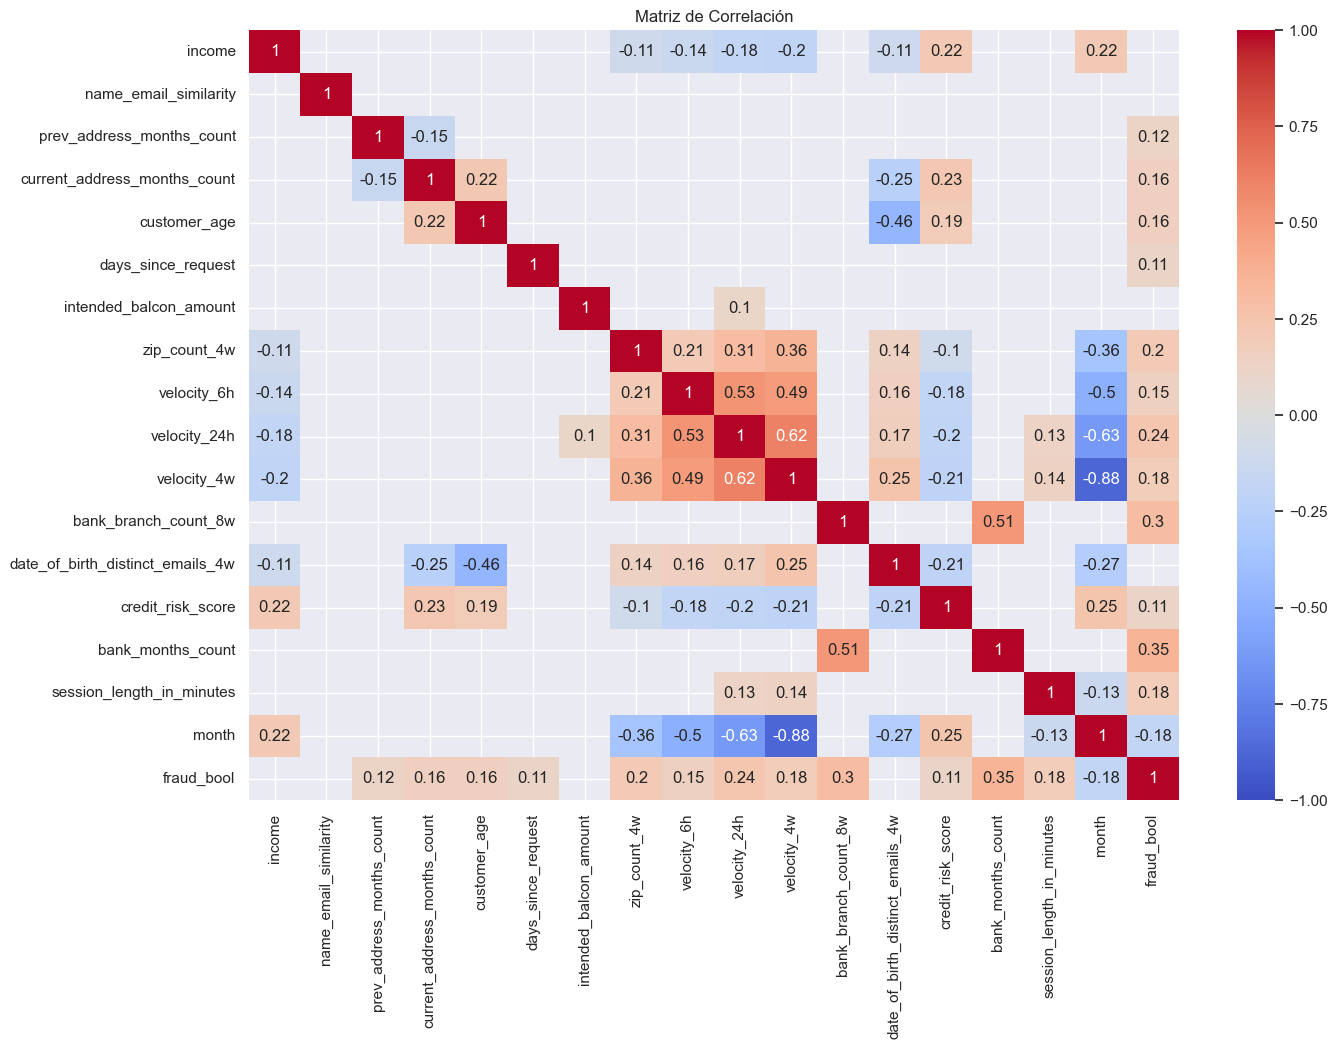

In [42]:
all_scaled_feature = x_scaled_feature[numerical_columns_corr].copy()
all_scaled_feature[target_var] = y_scaled_feature
matriz_correlacion = all_scaled_feature.corr()
# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(matriz_correlacion[(matriz_correlacion >= 0.1) | (matriz_correlacion <= -0.1)], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

In [43]:
df_corr_target = matriz_correlacion[target_var].reset_index()
df_corr_target['Abs coef. pearson'] = df_corr_target['fraud_bool'].abs()
df_corr_target = df_corr_target[df_corr_target['index']!=target_var]
df_corr_target = df_corr_target.rename(columns={'index': 'Variable','fraud_bool': 'Coeficiente de pearson'}).sort_values(by='Abs coef. pearson',ascending=False)
df_corr_target

,Variable,Coeficiente de pearson,Abs coef. pearson
14,bank_months_count,0.353167,0.353167
11,bank_branch_count_8w,0.303274,0.303274
9,velocity_24h,0.239564,0.239564
7,zip_count_4w,0.203476,0.203476
15,session_length_in_minutes,0.183557,0.183557
10,velocity_4w,0.181824,0.181824
16,month,-0.181619,0.181619
4,customer_age,0.161054,0.161054
3,current_address_months_count,0.158561,0.158561
8,velocity_6h,0.150872,0.150872


In [44]:
#Se toman las variables que tiene un valor del coeficiente de pearson mayor a 0.20 
numeric_preselected_variables = df_corr_target[df_corr_target['Abs coef. pearson']>0.20]['Variable'].to_list()
numeric_preselected_variables

['bank_months_count', 'bank_branch_count_8w', 'velocity_24h', 'zip_count_4w']

##### Conclusión
Se selecciona variables con una correlación más fuerte (|r| ≥ 0.3) que en este caso son las más cercanas al valor por lo que se toman las variables que tengan un valor mayo a 0.20 dando como resultado las siguientes variables `velocity_24h`, `bank_months_count`, `zip_count_4w`, `bank_branch_count_8w`.

### Analisis con un modelo de machine learning
Se analiza la importancia de las variables con respecto a la variable objetico y seleccionar las variables que pueden aportar al modelo para ello se va a seleccionar ExtraTreesClassifier debido a su capacidad de  para calcular la importancia de las caracteristicas.

In [45]:
from sklearn.feature_selection import RFE

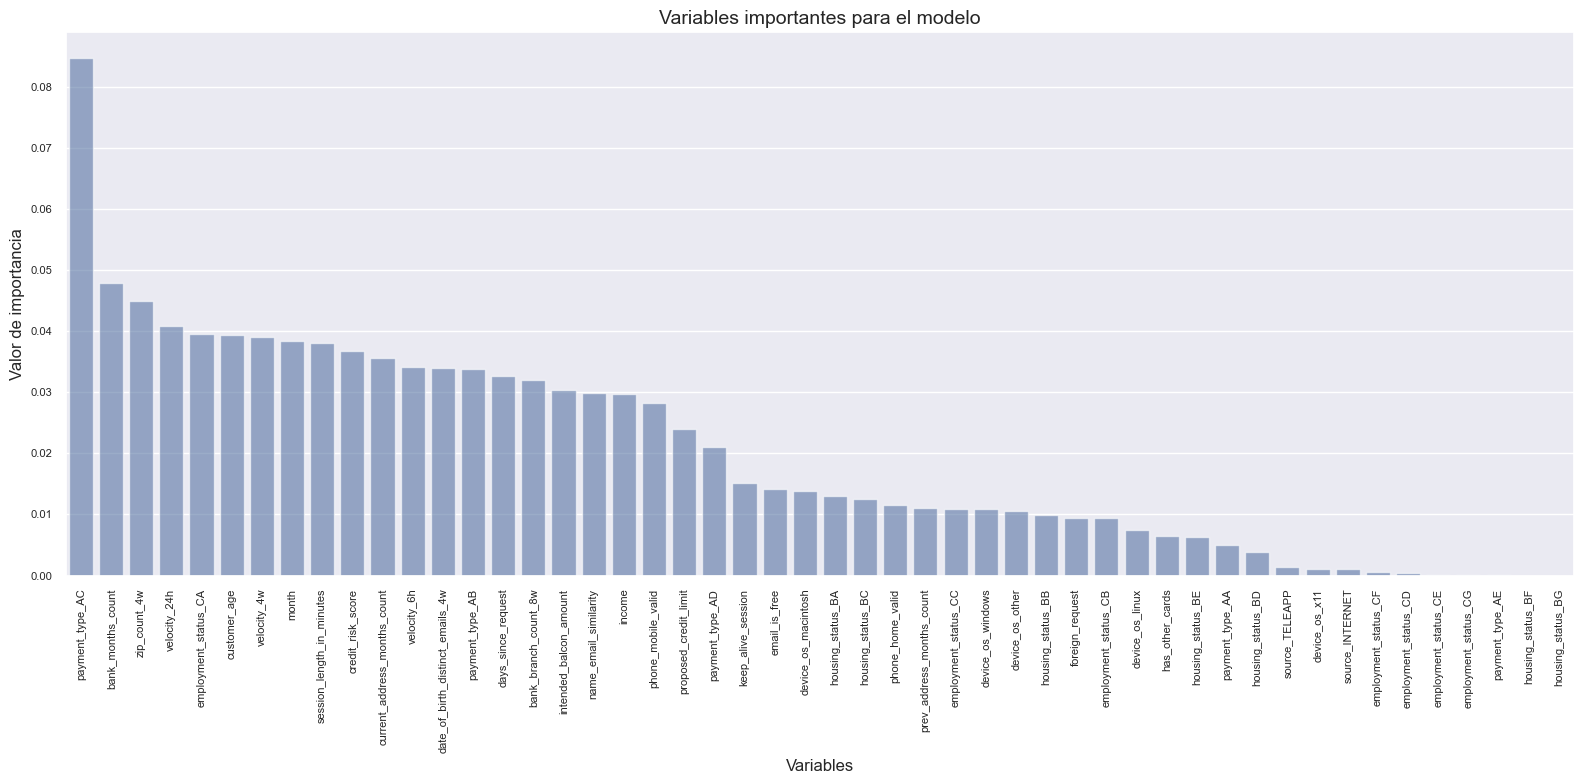

In [46]:
extra_trees = ExtraTreesClassifier(random_state=random_seed)
extra_trees.fit(x_scaled_feature, y_scaled_feature)
feature_sel_extra = SelectFromModel(extra_trees, prefit=True)
best_extra_features = [x_scaled_feature.columns[(feature_sel_extra.get_support())]]
best_extra_features = list(best_extra_features[0])

extra_importances = pd.DataFrame({'feature': x_scaled_feature.columns, 'importance': extra_trees.feature_importances_, 'model': 'ExtraTreesClassifier'})

plt.figure(figsize=(16, 8))
sns.barplot(data=extra_importances.sort_values(by='importance', ascending=False), x="feature", y="importance", alpha=.6)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Valor de importancia", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Variables importantes para el modelo", fontsize=14)
plt.tight_layout()
plt.show()

In [47]:
rfe = RFE(estimator=extra_trees, n_features_to_select=20)
rfe.fit(x_scaled_feature, y_scaled_feature)

# Obtener las variables seleccionadas por RFE
rfe_selected_features = x_scaled_feature.columns[rfe.support_].tolist()

df_selected_features = pd.DataFrame(x_scaled_feature.columns[rfe.support_], columns=['Selected Features'])
df_selected_features

,Selected Features
0,income
1,name_email_similarity
2,current_address_months_count
3,customer_age
4,days_since_request
5,intended_balcon_amount
6,zip_count_4w
7,velocity_6h
8,velocity_24h
9,velocity_4w


In [48]:
df_selected_features['Selected Features'].to_list()

['income',
 'name_email_similarity',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'phone_mobile_valid',
 'bank_months_count',
 'session_length_in_minutes',
 'month',
 'payment_type_AB',
 'payment_type_AC',
 'employment_status_CA']

##### Conclusión
En la selección de características numéricas analizadas previamente y utilizando el algoritmo ExtraTreesClassifier, se observa que las mejores características numéricas corresponden a todas aquellas que habían sido preseleccionadas, ya que todas tienen importancia en el modelo.

En la selección de características categóricas analizadas previamente, también utilizando ExtraTreesClassifier, se presenta una discrepancia, ya que muchas de las variables categóricas no fueron seleccionadas. El algoritmo ha priorizado solo las variables numéricas, por lo que se ha decidido conservar las variables preseleccionadas para este paso. \
Finalmente, tras el análisis de características, se han seleccionado las siguientes variables para los pasos posteriores:

In [49]:
all_features_selected = binary_preselected_variables+numeric_preselected_variables
all_features_selected

['housing_status_BB',
 'has_other_cards',
 'device_os_windows',
 'phone_home_valid',
 'housing_status_BE',
 'payment_type_AB',
 'device_os_macintosh',
 'employment_status_CB',
 'housing_status_BD',
 'foreign_request',
 'employment_status_CF',
 'payment_type_AD',
 'employment_status_CC',
 'bank_months_count',
 'bank_branch_count_8w',
 'velocity_24h',
 'zip_count_4w']

## Analisis de los datos preprocesados
Se analiza los datos depués de realizar el preprocesamiento para poder visualizar como estan distribuidos 

In [50]:
def analysis_numeric_column(df, ylabel="Frecuencia", xlabel="Distribución"):
    num_cols = df.select_dtypes(include=['number']).columns  # Seleccionar solo columnas numéricas
    num_plots = min(len(num_cols), 6)  # Limitar a 6 gráficos como máximo

    fig, axes = plt.subplots(3, 2, figsize=(12, 8))  # Crear una cuadrícula de 3x2 subgráficas
    axes = axes.flatten()  # Convertir en lista para iterar fácilmente

    for i, col in enumerate(num_cols[:num_plots]):  # Iterar solo sobre las primeras 6 columnas numéricas
        ax = axes[i]
        
        # Crear histograma con seaborn
        sns.histplot(df[col], bins=30, kde=True, ax=ax, color='skyblue')
        
        # Configurar etiquetas y título
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_title(f'Distribución de {col}', fontsize=12)

    # Eliminar ejes vacíos si hay menos de 6 columnas numéricas
    for j in range(i + 1, 6):
        fig.delaxes(axes[j])

    # Ajustar diseño para evitar solapamientos
    plt.tight_layout()
    plt.show()


def analysis_categorical_columns(df, ylabel='Frecuencia', xlabel=''):
    fig, axes = plt.subplots(4, 4, figsize=(16, 14))
    axes = axes.flatten()
    
    for i, col in enumerate(df.columns):
        if i >= 16: 
            break
        
        value_cont = df[col].value_counts()
        ax = axes[i]
        bars = ax.bar(value_cont.index.astype(str), value_cont, color='skyblue')

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', va='bottom')

        ax.set_xticklabels(value_cont.index.astype(str), fontsize=10)
        ax.set_yticklabels(ax.get_yticks(), fontsize=10)
        
        if ylabel:
            ax.set_ylabel(ylabel, fontsize=10)
        if xlabel:
            ax.set_xlabel(xlabel, fontsize=10)
        
        ax.set_title(f'{col}', fontsize=10)
    
    plt.tight_layout()
    plt.show()


### Analisis de las variables categoricas

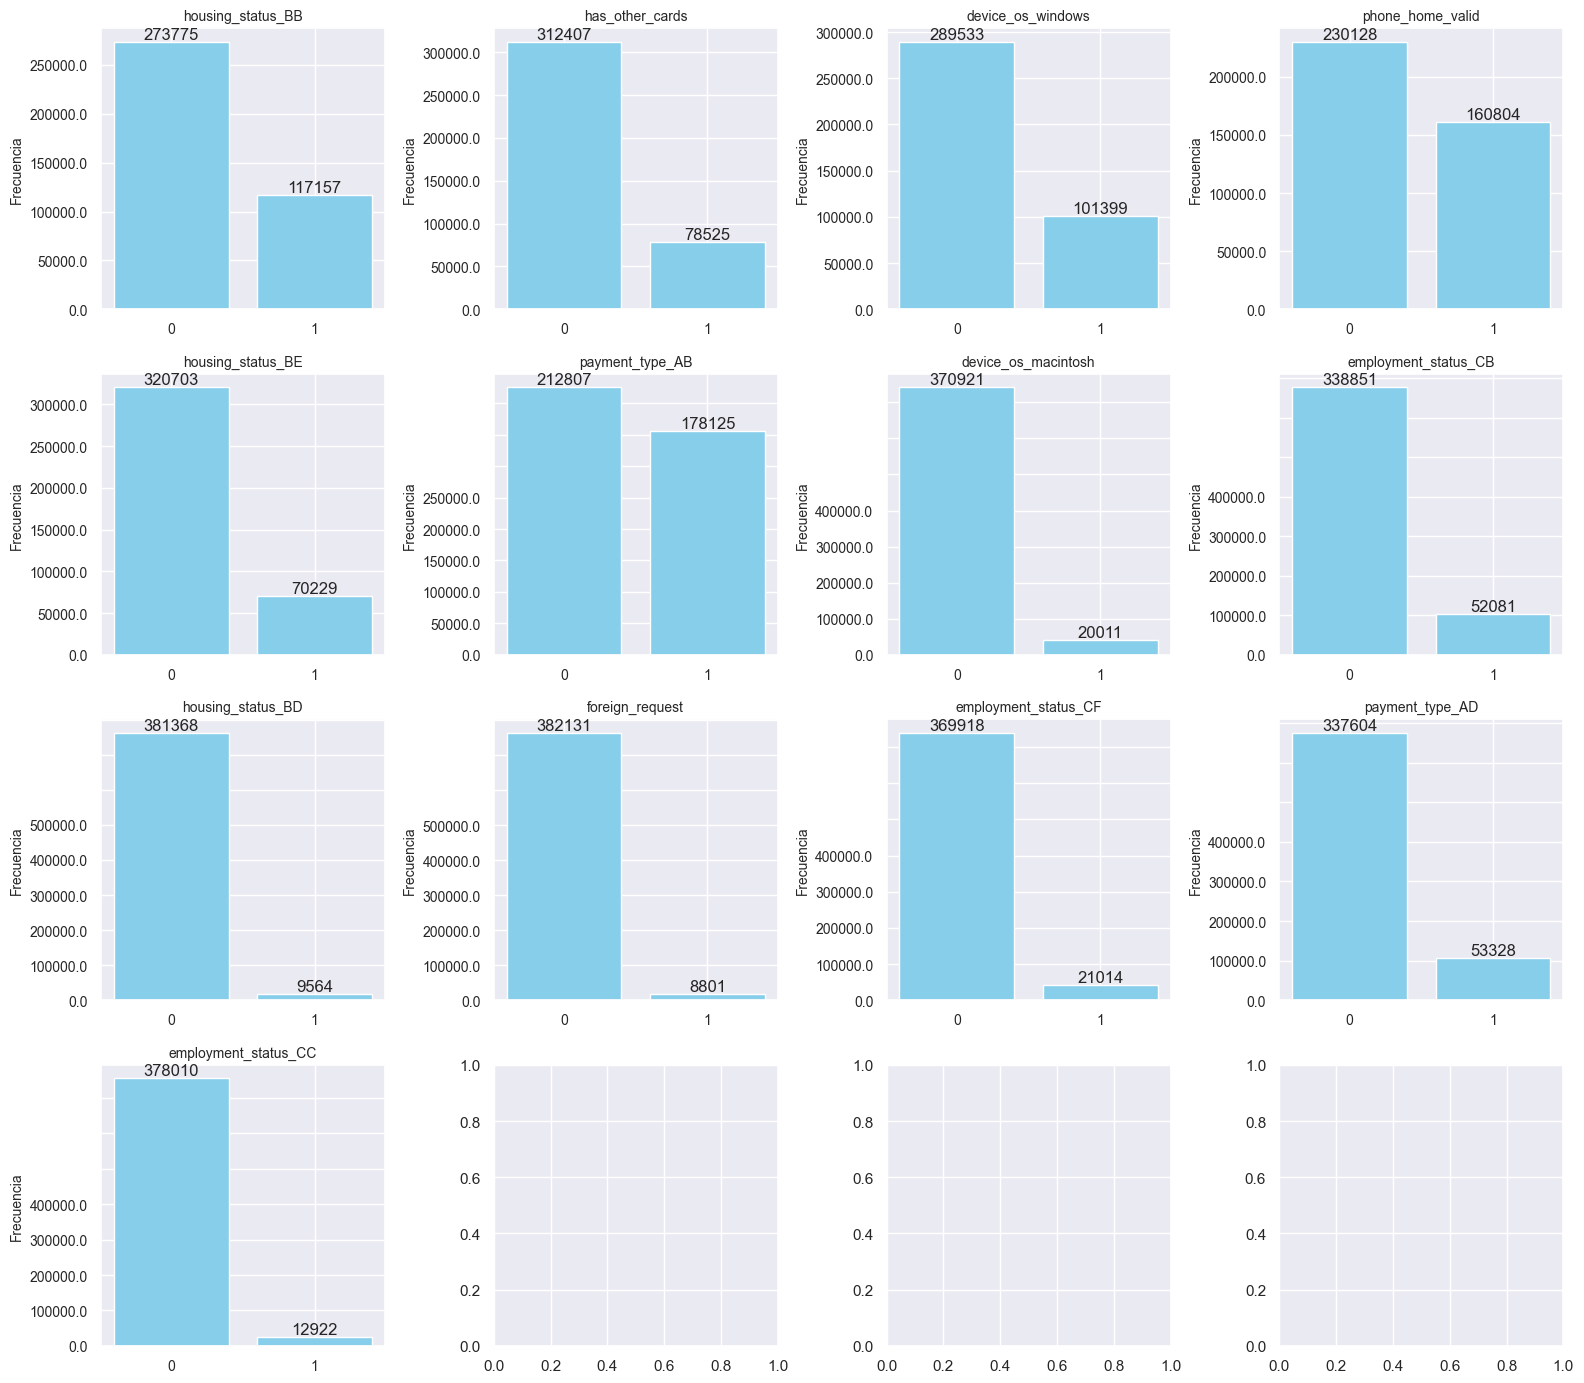

In [51]:
analysis_categorical_columns(data_feature_selection[binary_preselected_variables])

### Analisis de las variables numericas

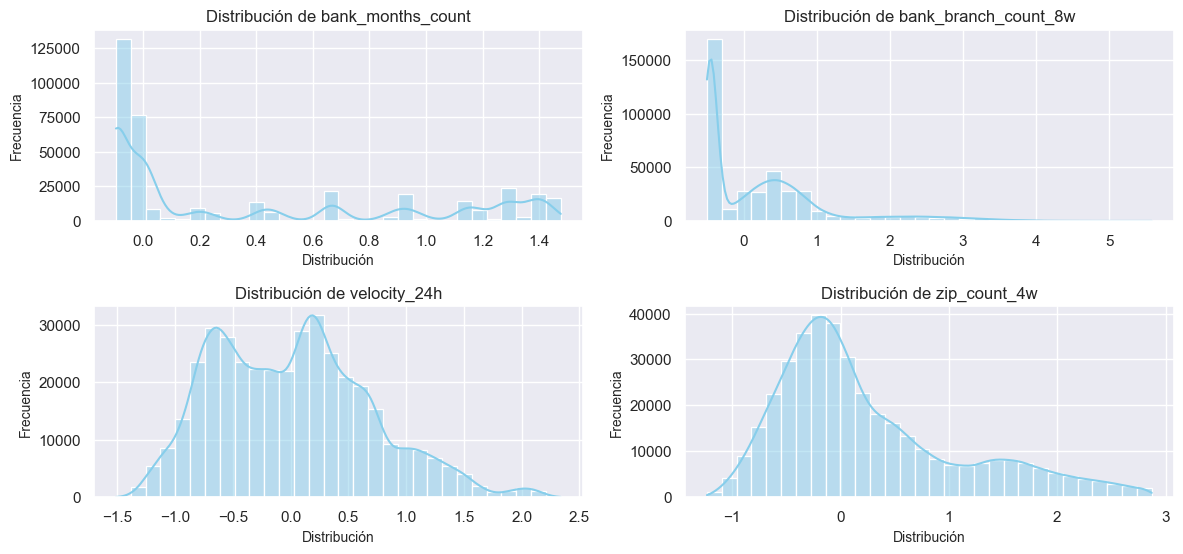

In [52]:
analysis_numeric_column(data_feature_selection[numeric_preselected_variables])

### Revisión de normalidad en los datos numericos

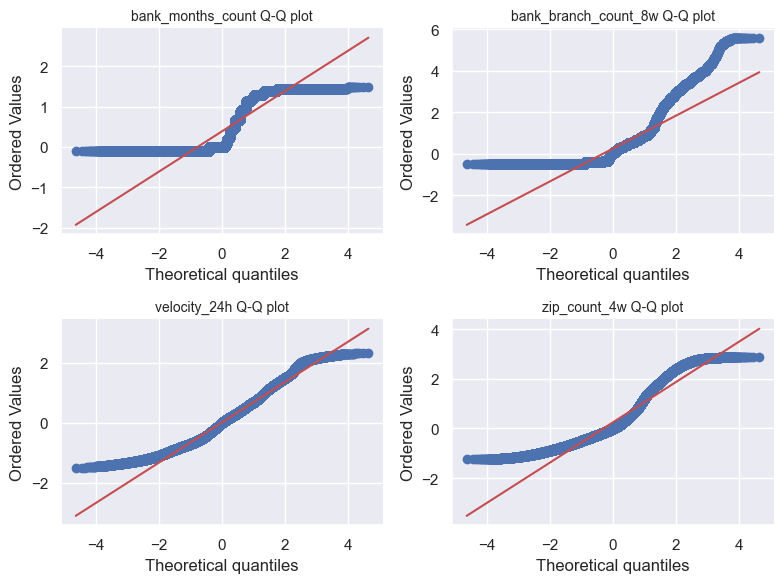

In [53]:
def check_normality(features, data_frame):
    num_features = len(features)
    cols = 2 
    rows = int(np.ceil(num_features / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        stats.probplot(data_frame[feature], dist=stats.norm, plot=axes[i])
        axes[i].set_title(f'{feature} Q-Q plot', fontsize=10)
        sns.despine()
        
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Llamada a la función con tus datos
check_normality(numeric_preselected_variables, data_feature_selection)

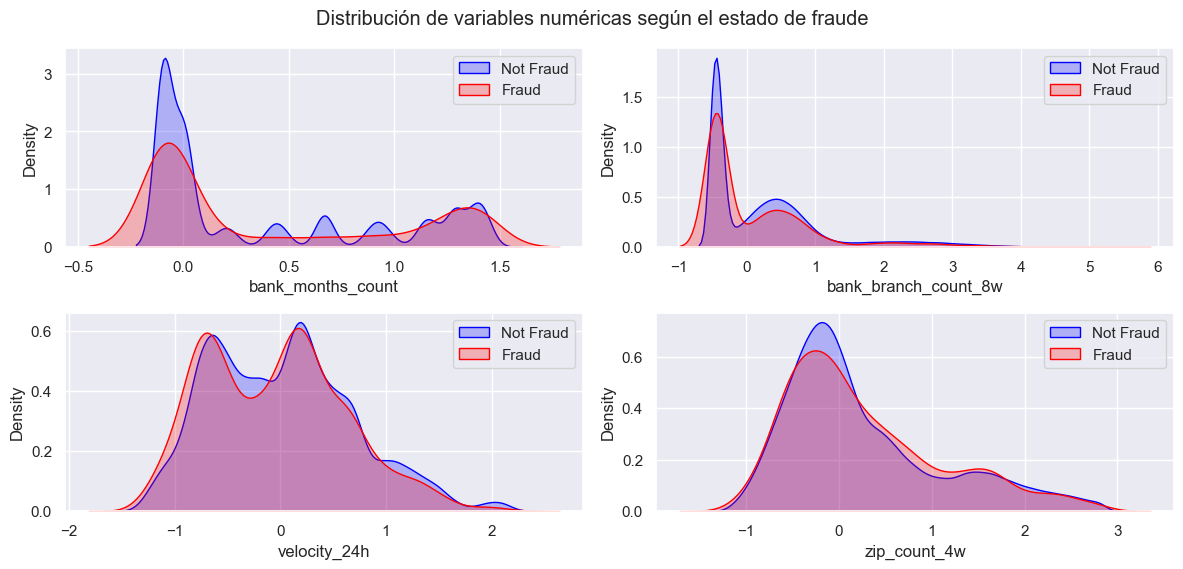

In [54]:
def bivariante_graphs_numerical(df, target_var):
    columns = df.select_dtypes(include=['number']).columns.tolist()  # Solo columnas numéricas
    if target_var in columns:
        columns.remove(target_var)  # Remover la variable objetivo

    num_plots = min(len(columns), 6)  # Máximo 6 gráficos
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))  # Crear figura 3x2
    axes = axes.flatten()  # Aplanar para fácil iteración

    fig.suptitle('Distribución de variables numéricas según el estado de fraude')

    for i, feature in enumerate(columns[:num_plots]):  # Iterar solo sobre las primeras 6 variables
        ax = axes[i]
        sns.kdeplot(data=df[df[target_var] == 0][feature],fill=True, ax=ax, label='Not Fraud', color='blue')
        sns.kdeplot(data=df[df[target_var] == 1][feature],fill=True, ax=ax, label='Fraud', color='red')
        ax.set_xlabel(feature)
        ax.legend()

    # Eliminar gráficos vacíos si hay menos de 6 variables
    for j in range(i + 1, 6):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

bivariante_graphs_numerical(data_feature_selection[numeric_preselected_variables+[target_var]],target_var)

Finalizado el preprocesamiento de los datos guardamos el dataset con la variables a usar en la creación de los modelos

In [55]:
data_preprocesed = data_feature_selection[all_features_selected+[target_var]].copy()
X = data_preprocesed.drop(columns=[target_var])  # Variables independientes
y = data_preprocesed[target_var]  # Variable objetivo

# Dividir en 80% entrenamiento y 20% prueba, ademas con stratify hace que la proporción se mantenga
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

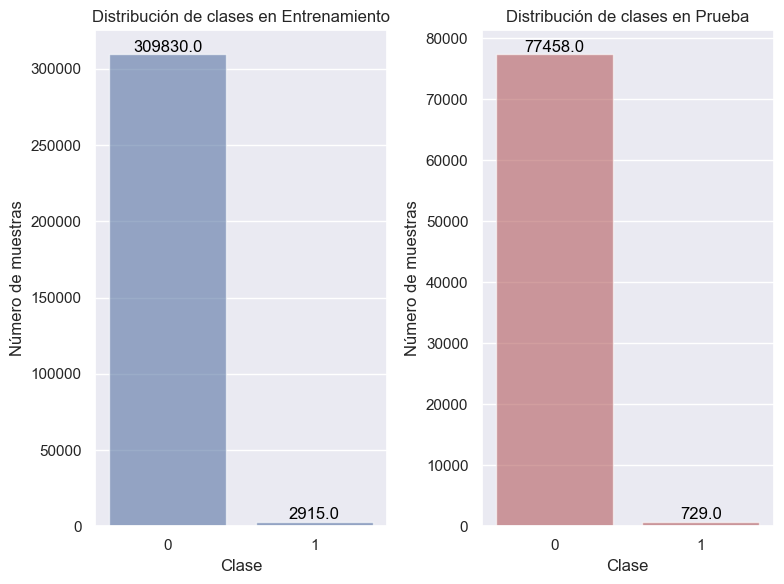

In [56]:
# Crear una figura con dos subgráficas
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

# Graficar la distribución de clases en el conjunto de entrenamiento
sns.countplot(x=y_train, color='b', alpha=0.6, ax=ax[0])
ax[0].set_title('Distribución de clases en Entrenamiento')
ax[0].set_xlabel('Clase')
ax[0].set_ylabel('Número de muestras')

# Añadir valores encima de las barras en la gráfica de entrenamiento
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Graficar la distribución de clases en el conjunto de prueba
sns.countplot(x=y_test, color='r', alpha=0.6, ax=ax[1])
ax[1].set_title('Distribución de clases en Prueba')
ax[1].set_xlabel('Clase')
ax[1].set_ylabel('Número de muestras')

# Añadir valores encima de las barras en la gráfica de prueba
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Ajustar el layout para que no se sobrepongan
plt.tight_layout()
plt.show()

In [58]:
train_data

,housing_status_BB,has_other_cards,device_os_windows,phone_home_valid,housing_status_BE,payment_type_AB,device_os_macintosh,employment_status_CB,housing_status_BD,foreign_request,employment_status_CF,payment_type_AD,employment_status_CC,bank_months_count,bank_branch_count_8w,velocity_24h,zip_count_4w,fraud_bool
165305,0,0,1,0,0,1,0,0,0,0,0,0,0,0.047619,0.416667,0.418747,0.341463,0
89346,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.095238,-0.416667,1.479093,1.142276,0
360472,0,0,1,1,1,0,0,0,0,0,0,1,0,1.142857,-0.250000,-0.819882,0.670732,0
221885,1,0,0,0,0,1,0,0,0,0,0,0,0,1.238095,-0.333333,2.044367,2.052846,0
2736,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000,0.583333,-0.272539,1.215447,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340682,0,1,0,1,0,0,0,0,0,0,0,0,0,1.142857,0.583333,1.021224,0.412602,0
211291,0,0,0,1,0,0,0,0,0,0,0,1,0,1.428571,0.250000,0.392879,1.433943,0
233045,0,0,0,0,1,0,0,0,0,0,0,1,0,0.428571,0.000000,0.355330,0.472561,0
367609,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.095238,-0.416667,-0.888599,-0.553862,0


In [59]:
# Crear DataFrames de los datos de entrenamiento y prueba
train_data = pd.concat([X_train, y_train], axis=1)
train_data.reset_index(inplace=True,drop=True)
test_data = pd.concat([X_test, y_test], axis=1)
test_data.reset_index(inplace=True,drop=True)

# Guardar los DataFrames en archivos CSV
train_data.to_csv('../../data/processed/train_data.csv', index=False)
test_data.to_csv('../../data/processed/test_data.csv', index=False)
